# **METK Barley SNP-Chip:** Exploring the correlation between barley’s genetic makeup and its protein content
## Importing and editing the necessary datasets

In [1]:
import pandas as pd
import numpy as np
snip_data = pd.read_csv("SNIP_DATA.csv")
barley_data = pd.read_csv("BARLEY_DATA.csv")

In [2]:
# Giving the first column in "SNIP_DATA.csv" a header since it was originally unnamed
snip_data.rename(columns={snip_data.columns[0]: 'SNP'}, inplace=True)

# Dropping ID column for "BARLEY_DATA.csv"
barley_data = barley_data.drop(columns='Id')

## Cleaning dataset 'SNIP_DATA.csv' based on the following criteria: 
### 1. Handling 'failed' values by replacing them with NaN

In [3]:
snip_data.replace('failed', np.nan, inplace=True)

### 2. Removing SNPs with the same allele across all varieties

In [4]:
# Excluding the first column
snp_columns = snip_data.columns[1:]

# Filtering rows where there's more than one unique value in the SNP columns 
# This ignores NaN values so that if the row is ["A", "A", "A", "A", NaN, NaN] then it is still removed although there's 2 different values
snip_data = snip_data[snip_data[snp_columns].apply(lambda row: row.dropna().nunique() > 1, axis=1)]

### 3. Removing barley varieties that are not present in both datasets

In [5]:
# Function to normalize variety names because
# in dataset barley_data some varieties presented in form '5777.7.1.2' are written as 5777712 in snip_data
def normalize_variety_names(variety):
    return str(variety).replace('.', '')

In [6]:
# Normalizing variety names in barley_data
barley_data['Nimi'] = barley_data['Nimi'].apply(normalize_variety_names)

# Extracting variety names from snip_data (columns starting from the second column)
snip_varieties = set(snip_data.columns[1:])

# Extracting variety names from barley_data (row values in the appropriate column)
barley_varieties = set(barley_data['Nimi'])

# Finding common varieties
common_varieties = snip_varieties.intersection(barley_varieties)

# Filtering snip_data to keep only common varieties
snip_data = snip_data[['SNP'] + list(common_varieties)]

# Filtering barley_data to keep only rows with common varieties
barley_data = barley_data[barley_data['Nimi'].isin(common_varieties)]

## Processing the datasets 
### **In preparation for finding correlations between protein content and genetic makeup**

In [7]:
# Creating a copy with only the barley variety and protein columns
protein_data = barley_data[['Nimi', 'Proteiin']].copy()

### Merging datasets on variety name

In [8]:
# Transposing snip_data to have barley varieties as rows not columns
snip_data_transposed = snip_data.set_index('SNP').T.reset_index()
snip_data_transposed.rename(columns={'index': 'Nimi'}, inplace=True)


# Merging protein_data with the transposed snip_data
merged_data = protein_data.merge(snip_data_transposed, on='Nimi', how='inner')


## Preparing data for dendrogramm
### Converting the SNP genotypes into numeric values (0, 1, 2), 3 to represent homozygous reference, heterozygous, and homozygous alternate alleles and Nan values

In [9]:
snp_data= merged_data.drop(columns=['Proteiin', 'Nimi'], axis=1)
# Ambiguity code to possible alleles mapping
ambiguity_map = {
    'R': ['A', 'G'],
    'Y': ['C', 'T'],
    'S': ['G', 'C'],
    'W': ['A', 'T'],
    'K': ['G', 'T'],
    'M': ['A', 'C']
}

# Function to determine the reference and alternate alleles
def determine_reference_and_alternate(alleles):
    """
    Determine the reference and alternate alleles based on the frequency of alleles.
    Assumes that the genotypes are given as base pairs or ambiguity codes (e.g., 'A', 'C', 'R', 'M', etc.).
    """
    allele_counts = pd.Series([allele for allele in alleles for allele in convert_ambiguity_to_bases(allele)]).value_counts()

    # Reference allele is the most frequent, alternate allele is the second most frequent
    reference_allele = allele_counts.idxmax()  # Most frequent allele
    if(allele_counts.size<2):
        alternate_allele = reference_allele
    else:
        alternate_allele = allele_counts.drop(reference_allele).idxmax()  # Second most frequent allele
    
    return reference_allele, alternate_allele


# Function to convert ambiguous genotype symbols to base pairs
def convert_ambiguity_to_bases(allele):
    """
    Convert ambiguity codes to possible base pairs.
    """
    if allele in ambiguity_map:
        return ambiguity_map[allele]
    return [allele,allele ]  # If no ambiguity code, return the allele as is

# Function to convert genotypes to numeric (0, 1, 2)
def convert_snp_to_numeric(allele, ref_allele, alt_allele):
   
    if allele == ref_allele:
        return 0  # Homozygous reference
    elif allele == alt_allele:
        return 2  # Homozygous alternate
    elif allele in ambiguity_map:
        return 1  # Heterozygous
    else:
        return 3 #Nan

# Function to convert the entire SNP DataFrame to numeric values (0, 1, 2)
def convert_snp_dataframe(snp_df):
    snp_numeric_df = snp_df.copy()

    # Iterate over each SNP column
    for snp in snp_df.columns:
        alleles = snp_df[snp]
        
        # Determine the reference and alternate alleles based on the genotypes
        ref_allele, alt_allele = determine_reference_and_alternate(alleles)
        
        # Convert each genotype to numeric (0, 1, 2)
        snp_numeric_df[snp] = [convert_snp_to_numeric(allele, ref_allele, alt_allele) for allele in alleles]
    
    return snp_numeric_df

# Convert the SNP data to numeric format (0, 1, 2) and 3 represents NaN values

snp_numeric = convert_snp_dataframe(snp_data)
snp_numeric


,BK_01,BK_03,BK_05,BK_08,BK_10,BK_12,BK_14,BK_17,BK_19,BOPA1_10012-1239,...,TGBA15K-TG0384,TGBA15K-TG0385,TGBA15K-TG0386,TGBA15K-TG0388,TGBA15K-TG0395,TGBA15K-TG0400,TGBA15K-TG0402_NC_MA,TGBA15K-TG0402_NG_MA,TGBA15K-TG0403,TGBA15K-TG0409
0,3,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,2
3,0,0,0,2,0,0,0,2,0,0,...,0,0,2,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,0,0,0,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
167,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
168,0,0,0,2,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
169,0,0,0,0,0,0,0,0,0,2,...,0,0,2,0,0,0,0,0,0,0


## Removing certaing columns with to many NaN's

In [10]:
snp_Nan_below = snp_numeric.copy()
print(f'before removing nan {snp_Nan_below.shape}')
# Calculate the percentage of NaN values in each row
for marker in snp_Nan_below.columns:
    nan_percentage = (snp_Nan_below[marker] == 3).sum() / 171 * 100
    #print(nan_percentage)
        
    if (nan_percentage > 30):
        print(f'removed marker {marker}, % {nan_percentage}')
        snp_Nan_below = snp_Nan_below.drop(marker, axis = 1)

print(f'after removing nan {snp_Nan_below.shape}')

before removing nan (171, 11896)
removed marker BOPA2_12_30480, % 30.409356725146196
removed marker DUP-TGBA15K-TG0290, % 55.55555555555556
removed marker DUP-TGBA15K-TG0316, % 61.40350877192983
removed marker JHI-Hv50k-2016-110117, % 62.57309941520468
removed marker JHI-Hv50k-2016-20959, % 39.76608187134503
removed marker JHI-Hv50k-2016-230851, % 36.25730994152047
removed marker JHI-Hv50k-2016-286861, % 61.98830409356725
removed marker JHI-Hv50k-2016-323695, % 45.02923976608187
removed marker JHI-Hv50k-2016-420301, % 42.69005847953216
removed marker JHI-Hv50k-2016-468426, % 53.80116959064327
removed marker JHI-Hv50k-2016-63147, % 40.93567251461988
removed marker SCRI_RS_129198, % 31.57894736842105
removed marker SCRI_RS_136857, % 41.52046783625731
removed marker SCRI_RS_13964, % 38.59649122807017
removed marker SCRI_RS_148694, % 53.80116959064327
removed marker SCRI_RS_153388, % 58.47953216374269
removed marker SCRI_RS_158599, % 30.409356725146196
removed marker SCRI_RS_168141, % 36.8

## Compute Pairwise SNP Distances
### We will calculate pairwise distances using a simple Hamming distance, which counts the number of differing SNPs between samples and making a dendrogram

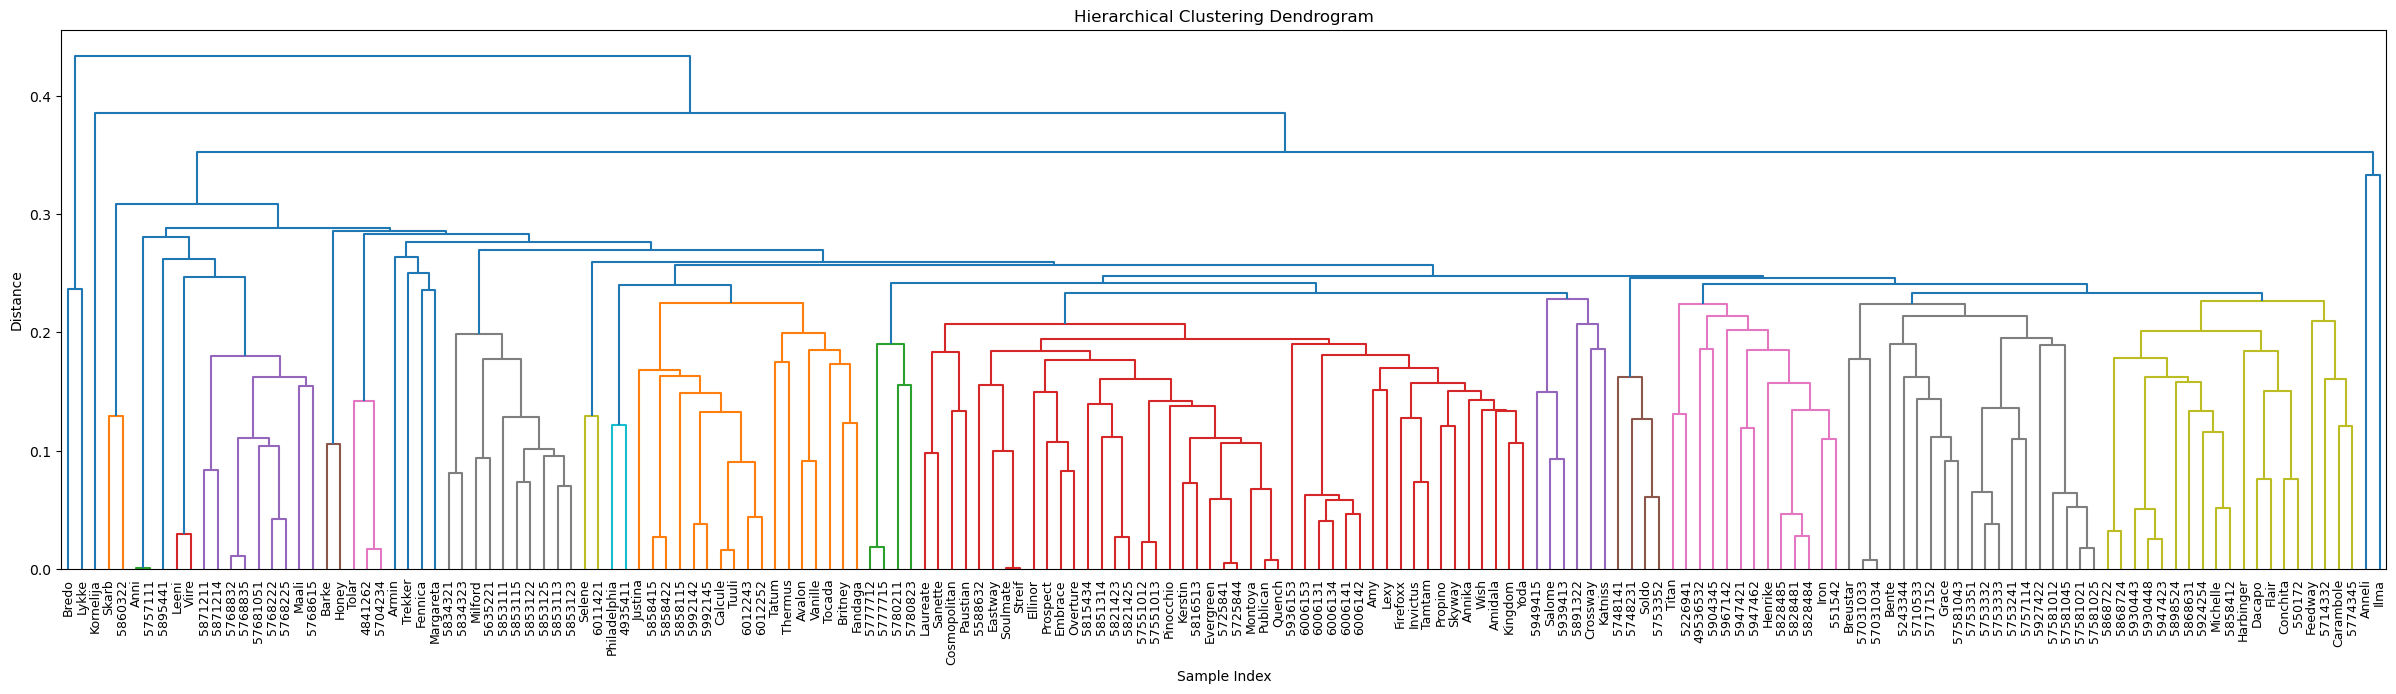

In [11]:

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

snp_numeric_cleaned = snp_Nan_below.copy()

snp_numeric_cleaned.index = merged_data['Nimi']


#Calculating Hamming distance between samples
def hamming_distance(snp_data):
    # Use pairwise Hamming distance metric on the SNP data, treating NaN as missing values
    return pdist(snp_data, metric='hamming')


# Computing the pairwise distance matrix using Hamming distance
distance_matrix = hamming_distance(snp_numeric_cleaned)  
distance_matrix_square = squareform(distance_matrix)

# Performing hierarchical clustering using the linkage function
Z = linkage(distance_matrix, method='average')  # 'average' linkage method

# Plotting the dendrogram
plt.figure(figsize=(30, 7))
dendrogram(Z, labels=snp_numeric_cleaned.index, color_threshold=0.23) 
plt.title("Hierarchical Clustering Dendrogram")
plt.xticks(fontsize = 9)
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()




## Finding most influencial markers
### In order to do that, we calculate average protein content for each group

#### Removing markers with 0 diference in alleels

In [12]:
snp_numeric_reduced = snp_numeric_cleaned.copy()
print(snp_numeric_reduced.shape)


# Step 1: Define a function to remove SNPs where 0, 1, or 2 + NaN make up 100% of the samples
def remove_snp_with_single_genotype_or_na(snp_data):
    # Step 2: Identify rows where one of the genotypes (0, 1, or 2) + NaN makes up 100%
    n_samples = snp_data.shape[0]
    
    # Step 3: Filter SNPs where any genotype (0, 1, or 2) + NaN make up 100% of the samples
    valid_snp = []
    for col in snp_data.columns:
        count_0 = (snp_data[col] == 0).sum()
        count_1 = (snp_data[col] == 1).sum()
        count_2 = (snp_data[col] == 2).sum()
        count_3 = (snp_data[col] == 3).sum()  # NaN is represented as 3

        # Check if 0, 1, or 2 + NaN make up 100% of the samples
        if (count_0 + count_3 == n_samples) or (count_1 + count_3 == n_samples) or (count_2 + count_3 == n_samples):
            valid_snp.append(False)  # Invalid SNP, remove it
            #print(f'{col} {count_0} {count_1} {count_2} {count_3}')
        else:
            valid_snp.append(True)  # Keep this SNP

    # Step 4: Remove the invalid SNPs
    snp_numeric_filtered = snp_data.loc[:, valid_snp]
    return snp_numeric_filtered

# Apply the function to your SNP data
snp_numeric_reduced = remove_snp_with_single_genotype_or_na(snp_numeric_reduced)

# Now 'snp_numeric_cleaned' contains only SNPs where 0, 1, 2 + NaN don't make up 100% of the samples
print(snp_numeric_reduced.shape)


(171, 11868)
(171, 11606)


In [13]:
data = snp_numeric_reduced.copy()
data

,BK_01,BK_03,BK_05,BK_08,BK_10,BK_17,BK_19,BOPA1_10012-1239,BOPA1_10070-1435,BOPA1_1007-651,...,TGBA15K-TG0382,TGBA15K-TG0383,TGBA15K-TG0384,TGBA15K-TG0385,TGBA15K-TG0386,TGBA15K-TG0400,TGBA15K-TG0402_NC_MA,TGBA15K-TG0402_NG_MA,TGBA15K-TG0403,TGBA15K-TG0409
Nimi,,,,,,,,,,,,,,,,,,,,,
Amidala,3,0,0,0,3,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
Amy,0,0,0,0,0,0,0,2,0,2,...,0,0,0,0,0,0,0,0,0,0
Anneli,0,0,2,0,0,0,0,0,0,2,...,0,2,0,2,0,0,0,0,0,2
Anni,0,0,0,2,0,2,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
Annika,0,0,0,0,0,0,0,2,0,2,...,2,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6006142,0,0,0,2,0,0,0,1,0,2,...,0,2,0,0,0,0,0,0,0,0
6006153,0,0,0,0,0,0,0,2,0,2,...,0,2,0,0,0,0,0,0,0,0
6011421,0,0,0,2,0,0,0,0,0,2,...,0,0,0,0,2,0,0,0,0,0


#### Calculating average protein content in a group

In [14]:
snp_protein = snp_numeric_reduced.copy()
# Merging SNP data with protein content
snp_protein = snp_protein.merge(merged_data[['Nimi', 'Proteiin']], left_index=True, right_on='Nimi', how='left').drop(columns=['Nimi'])  # Add protein content to the data

# Creating a new dataframe to store average protein content for each genotype in each SNP marker
average_protein_content = {}

# Loop through each SNP marker (column in the SNP dataframe)
for marker in snp_protein.columns[:-1]:  # Excluding the last column ('Proteiin')
    # Group by genotype (0, 1, 2) and calculate the mean protein content for each group
    avg_protein = snp_protein.groupby(marker)['Proteiin'].mean()
    average_protein_content[marker] = avg_protein

# Converting the result into a DataFrame
average_protein_df = pd.DataFrame(average_protein_content)

print(average_protein_df)



       BK_01      BK_03      BK_05      BK_08      BK_10      BK_17  \
0  12.056338  12.062874  12.000000  12.172321  12.097419  12.105128   
1        NaN        NaN  12.100000        NaN        NaN        NaN   
2  12.475000  13.125000  12.784211  11.927119  11.776923  11.906667   
3  12.152381        NaN        NaN        NaN  12.933333        NaN   

       BK_19  BOPA1_10012-1239  BOPA1_10070-1435  BOPA1_1007-651  ...  \
0  12.088690         12.141053         12.087059       12.162931  ...   
1        NaN         12.100000               NaN             NaN  ...   
2  12.033333         12.020000         12.200000       11.929091  ...   
3        NaN               NaN               NaN             NaN  ...   

   TGBA15K-TG0382  TGBA15K-TG0383  TGBA15K-TG0384  TGBA15K-TG0385  \
0       12.196899       12.054255       12.075926       12.028125   
1             NaN             NaN             NaN             NaN   
2       11.752381       12.128571       12.300000       12.954545   
3 

In [15]:
#Removing row 3, since these are NaN value averages
average_protein_df_nonan =average_protein_df.drop(index=3)
average_protein_df_nonan

,BK_01,BK_03,BK_05,BK_08,BK_10,BK_17,BK_19,BOPA1_10012-1239,BOPA1_10070-1435,BOPA1_1007-651,...,TGBA15K-TG0382,TGBA15K-TG0383,TGBA15K-TG0384,TGBA15K-TG0385,TGBA15K-TG0386,TGBA15K-TG0400,TGBA15K-TG0402_NC_MA,TGBA15K-TG0402_NG_MA,TGBA15K-TG0403,TGBA15K-TG0409
0,12.056338,12.062874,12.000000,12.172321,12.097419,12.105128,12.088690,12.141053,12.087059,12.162931,...,12.196899,12.054255,12.075926,12.028125,12.083962,12.089881,12.113291,12.113291,12.112102,12.000000
1,NaN,NaN,12.100000,NaN,NaN,NaN,NaN,12.100000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.100000
2,12.475000,13.125000,12.784211,11.927119,11.776923,11.906667,12.033333,12.020000,12.200000,11.929091,...,11.752381,12.128571,12.300000,12.954545,12.095313,11.966667,11.776923,11.776923,11.814286,12.784211


In [16]:

# Step 2: Calculate max difference in protein content per SNP marker
max_differences = {}

# Loop through each SNP marker (column in the SNP dataframe)
for marker in snp_numeric_reduced.columns:  # Exclude the last column (Protein_Content)
    #print(f'{marker} max {average_protein_df[marker].max()}')
    #print(f'{marker} min {average_protein_df[marker].min()}')
   
    group_sizes = snp_numeric_reduced[marker].value_counts()

    # Get the size of each group (0, 1, 2)
    group_size_marker_0 = group_sizes.get(0, 0)
    group_size_marker_1 = group_sizes.get(1, 0)
    group_size_marker_2 = group_sizes.get(2, 0)
    num = 2
    
    #print(f'{marker} {group_size_marker_0} {group_size_marker_1} {group_size_marker_2} {group_size_marker_0 == 0 or group_size_marker_0 > num and group_size_marker_1 == 0 or group_size_marker_1> num and group_size_marker_2 == 0 or group_size_marker_2> num}')
    if((group_size_marker_0 == 0 or group_size_marker_0 > num) and (group_size_marker_1 == 0 or group_size_marker_1> num) and (group_size_marker_2 == 0 or group_size_marker_2> num)):
        max_protein = average_protein_df[marker].max() # Get the max protein content for each genotype
        min_protein = average_protein_df[marker].min()  # Get the min protein content for each genotype
    else :
        max_protein = 0 
        min_protein = 0
        
    # Calculate the difference between max and min for each SNP
    max_difference = (max_protein - min_protein)  # Find the max difference across genotypes for the marker
    max_differences[marker] = max_difference  # Store the result in the dictionary

# Step 3: Convert the result into a DataFrame for easy inspection
max_difference_df_nonan = pd.DataFrame(list(max_differences.items()), columns=['SNP_Marker', 'Max_Protein_Difference'])

# Step 4: Sort the DataFrame in descending order by 'Max_Protein_Difference'
max_difference_df_sorted_nonan = max_difference_df_nonan.sort_values(by='Max_Protein_Difference', ascending=False)


# Step 4: Print or use the resulting DataFrame
print(max_difference_df_sorted_nonan.head(20))


                  SNP_Marker  Max_Protein_Difference
3618   JHI-Hv50k-2016-246473                3.561538
2692   JHI-Hv50k-2016-185706                3.551351
4347   JHI-Hv50k-2016-306041                3.522857
5198   JHI-Hv50k-2016-366603                3.493103
9567          SCRI_RS_168494                3.454545
10127         SCRI_RS_190416                3.250000
1889   JHI-Hv50k-2016-115953                2.931461
8947          SCRI_RS_150590                2.860000
7044      JHI-Hv50k-2016-498                2.858824
7812    JHI-Hv50k-2016-75908                2.421429
7772    JHI-Hv50k-2016-73966                2.421429
7814    JHI-Hv50k-2016-76081                2.421429
157           BOPA1_2020-539                2.421429
5250   JHI-Hv50k-2016-369625                2.183929
5276   JHI-Hv50k-2016-370683                2.183929
5225   JHI-Hv50k-2016-368227                2.183929
5219   JHI-Hv50k-2016-367854                2.183929
5258   JHI-Hv50k-2016-369872                2.

In [17]:
# Get the markers with the  Max_Protein_Difference above 2.5
protein_dif_treshold = 2.5
markers_above_threshold = max_difference_df_sorted_nonan[max_difference_df_sorted_nonan['Max_Protein_Difference'] > protein_dif_treshold]['SNP_Marker'].tolist()
print(markers_above_threshold)


['JHI-Hv50k-2016-246473', 'JHI-Hv50k-2016-185706', 'JHI-Hv50k-2016-306041', 'JHI-Hv50k-2016-366603', 'SCRI_RS_168494', 'SCRI_RS_190416', 'JHI-Hv50k-2016-115953', 'SCRI_RS_150590', 'JHI-Hv50k-2016-498']


## Vizulizing found markers

Plot for marker: JHI-Hv50k-2016-246473


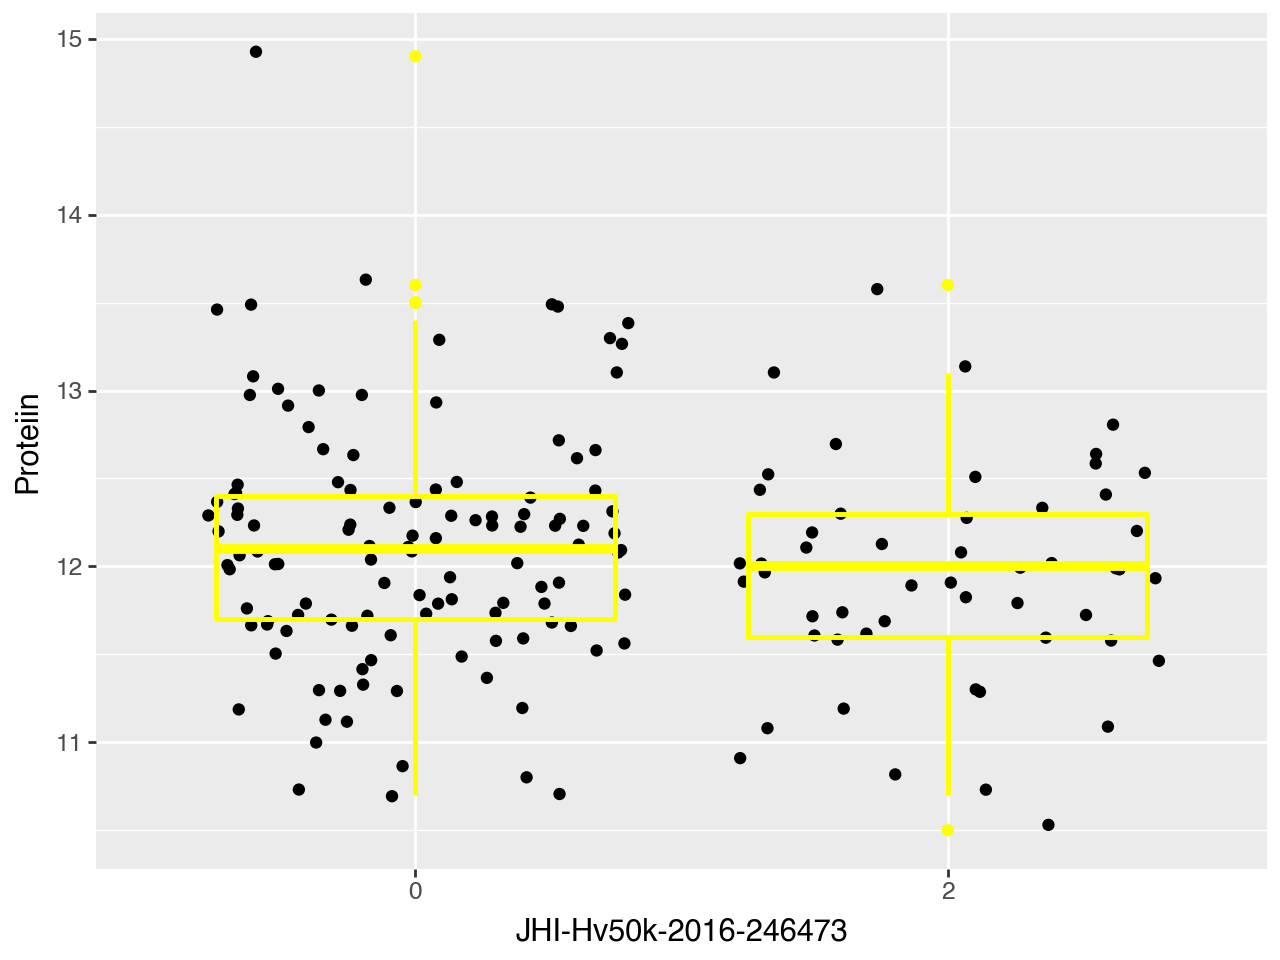

Plot for marker: JHI-Hv50k-2016-185706


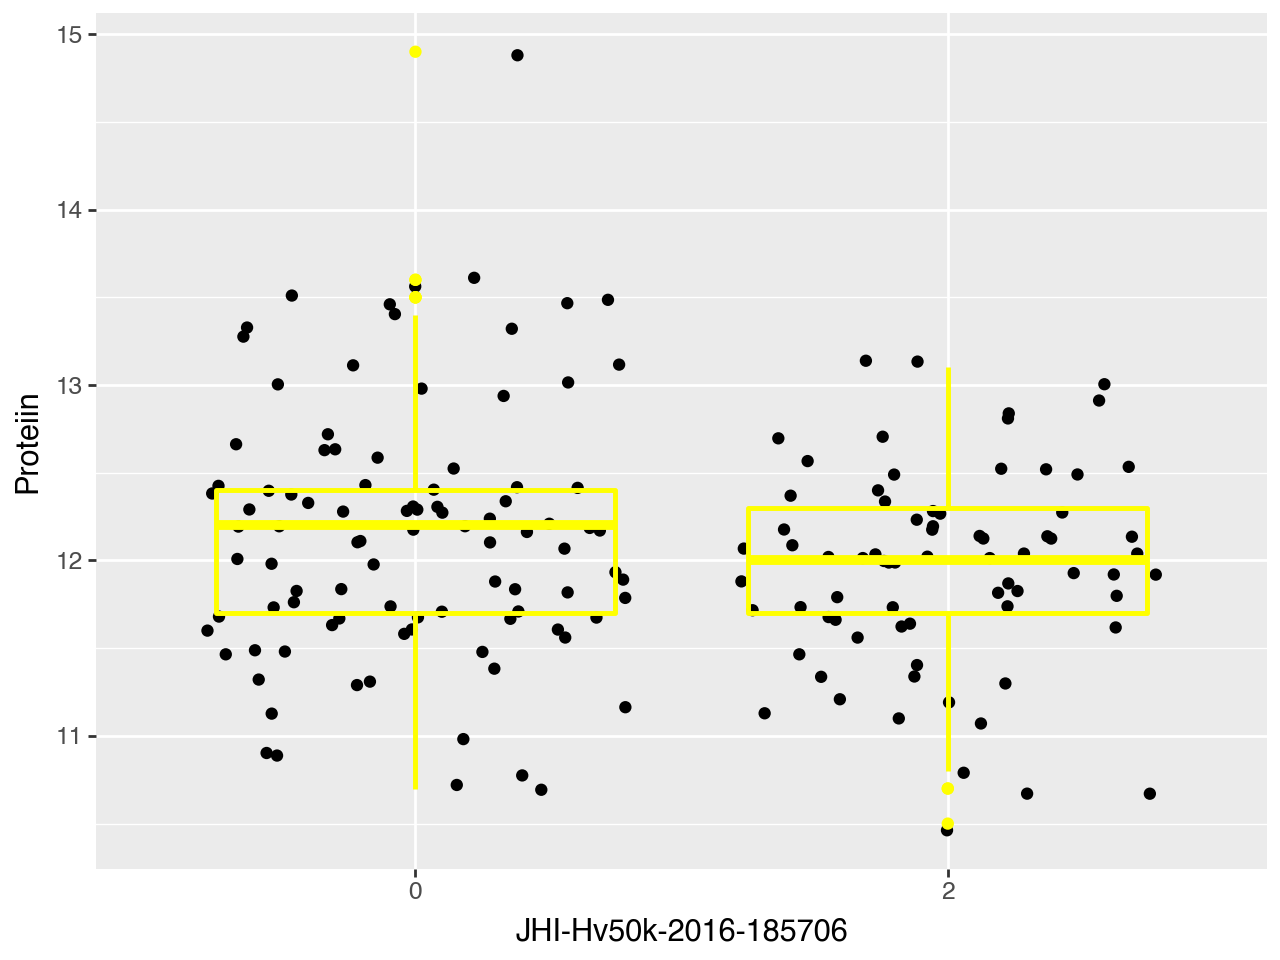

Plot for marker: JHI-Hv50k-2016-306041


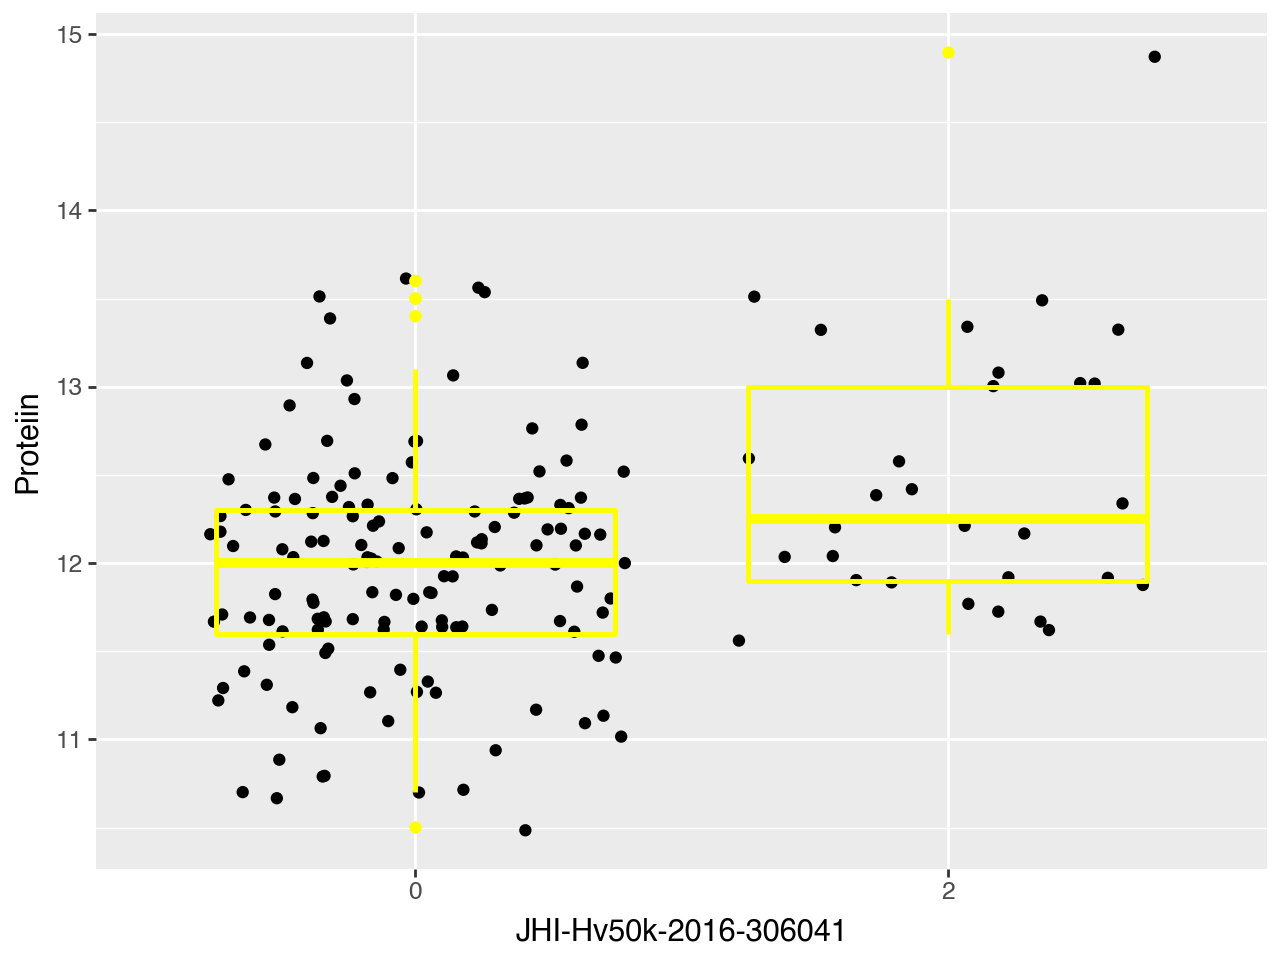

Plot for marker: JHI-Hv50k-2016-366603


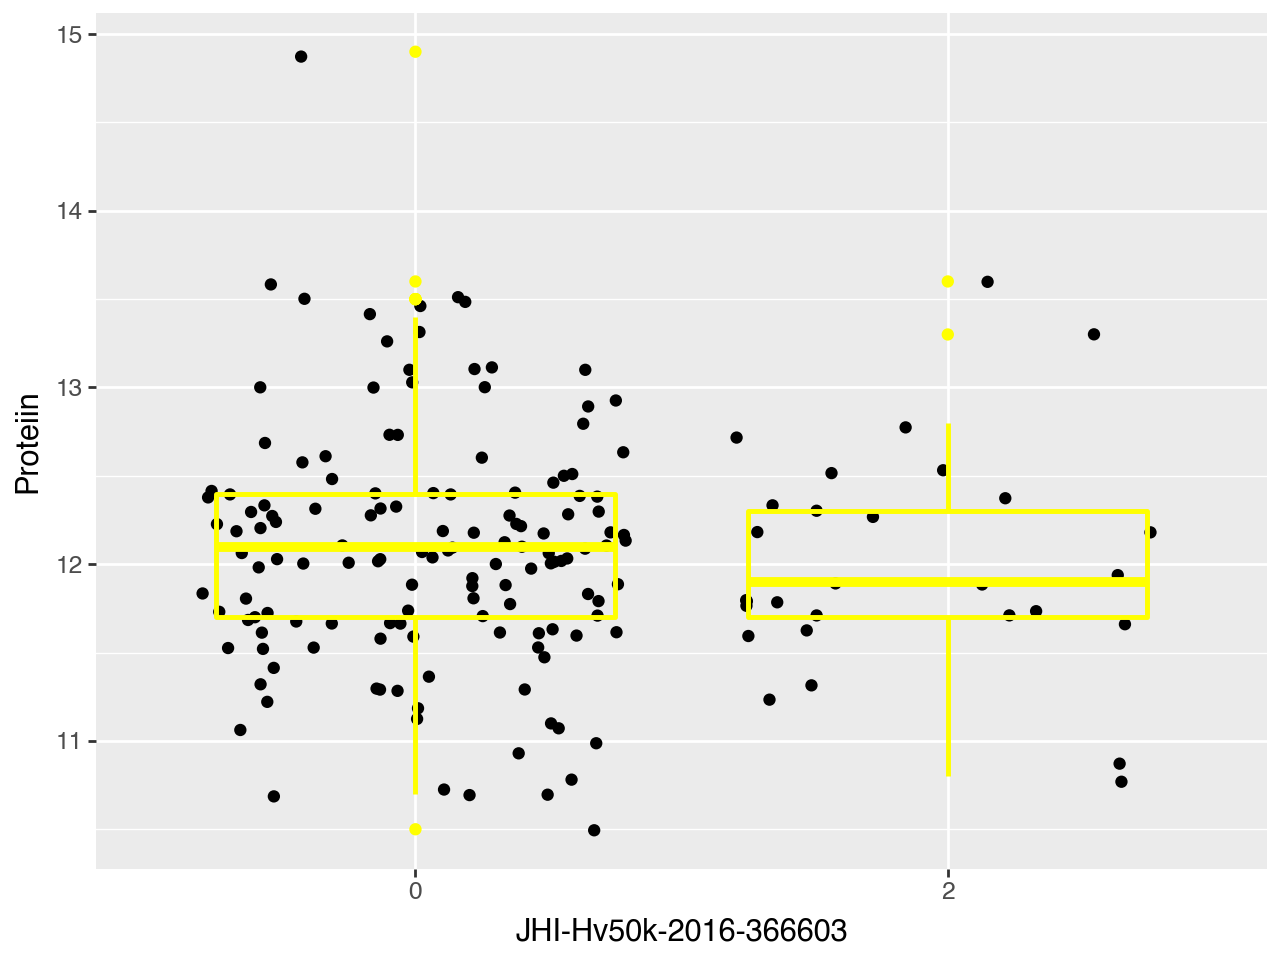

Plot for marker: SCRI_RS_168494


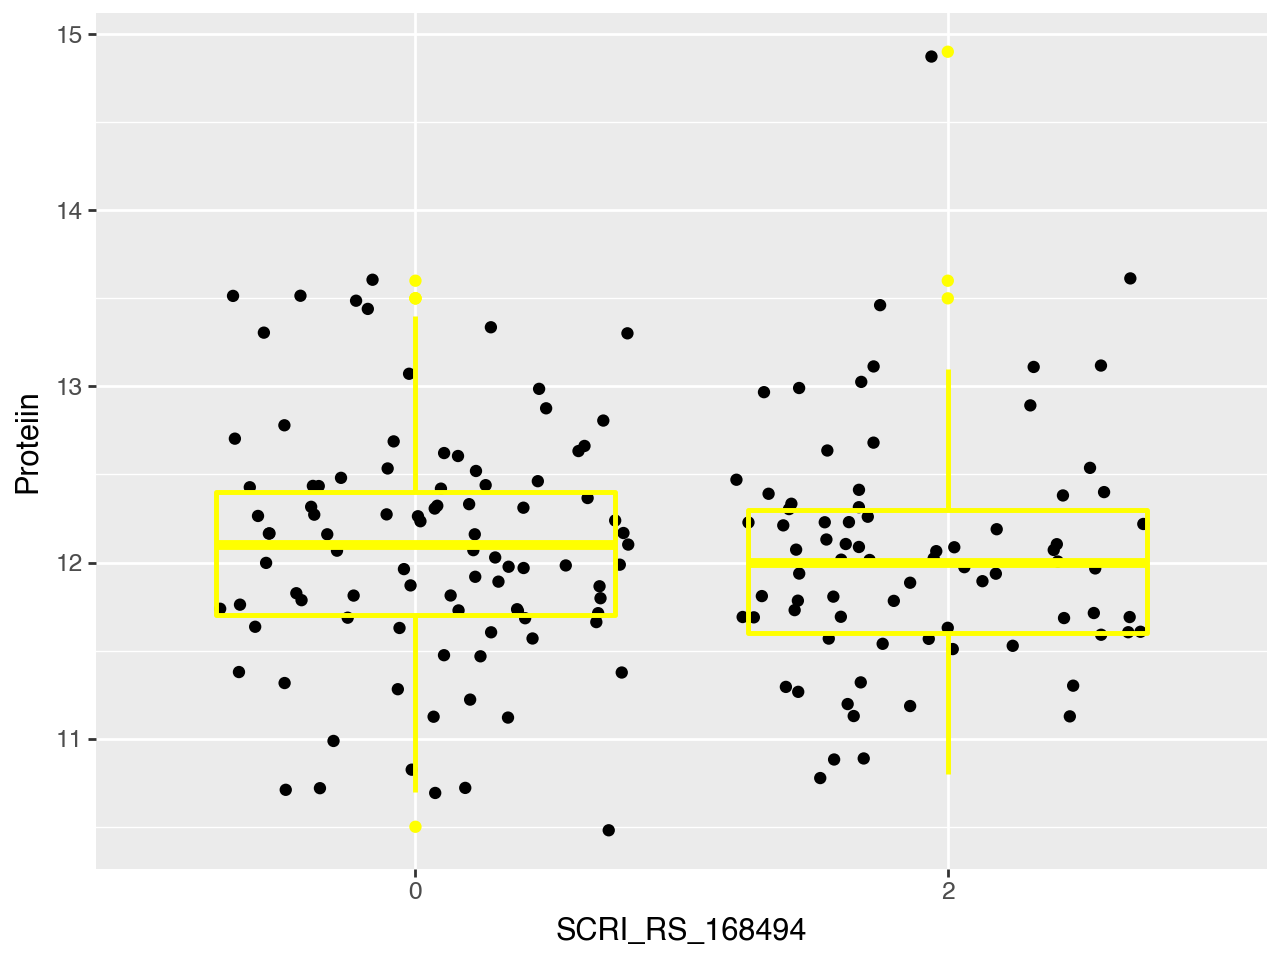

Plot for marker: SCRI_RS_190416


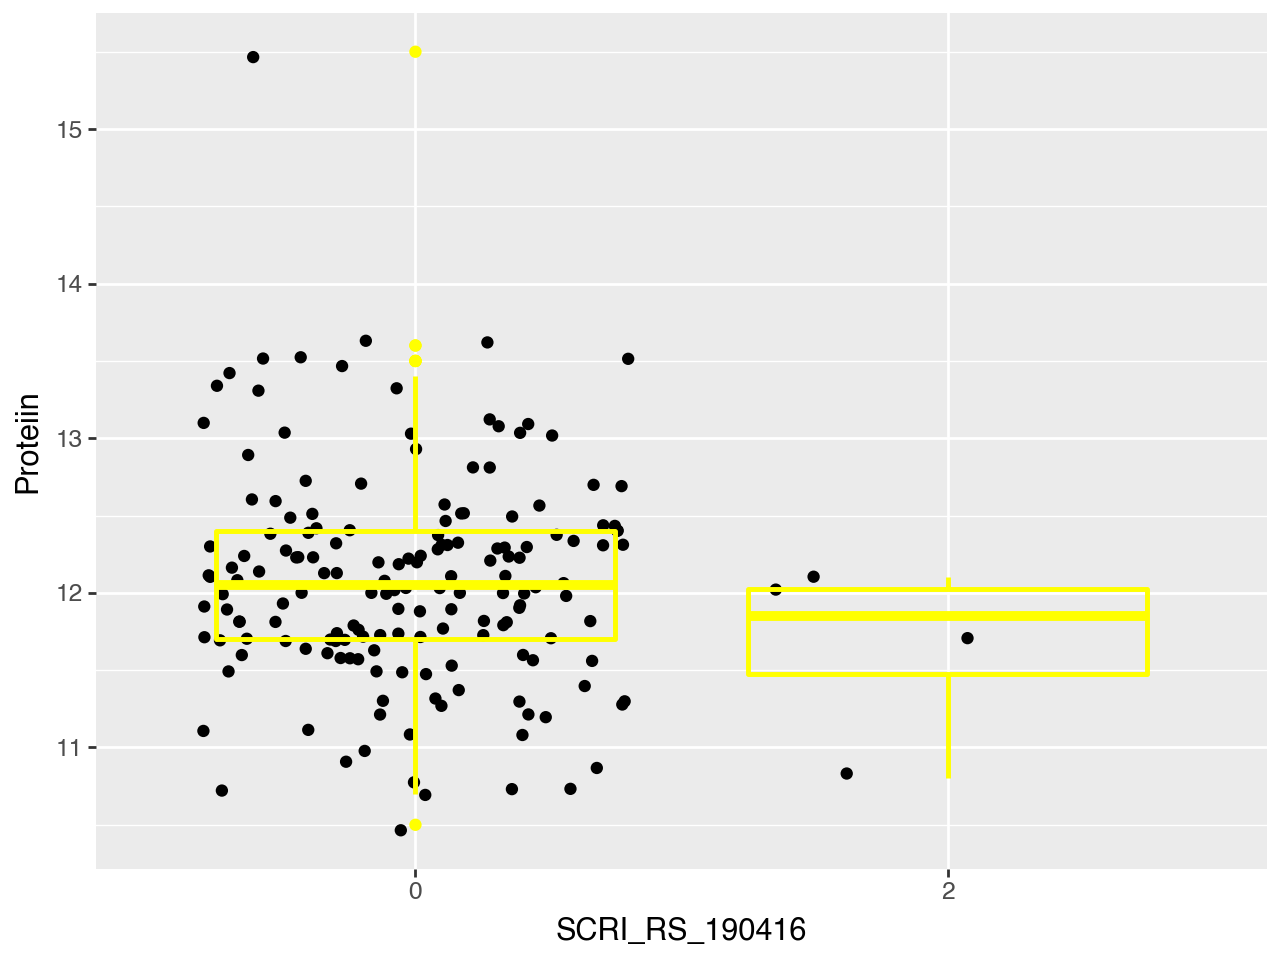

Plot for marker: JHI-Hv50k-2016-115953


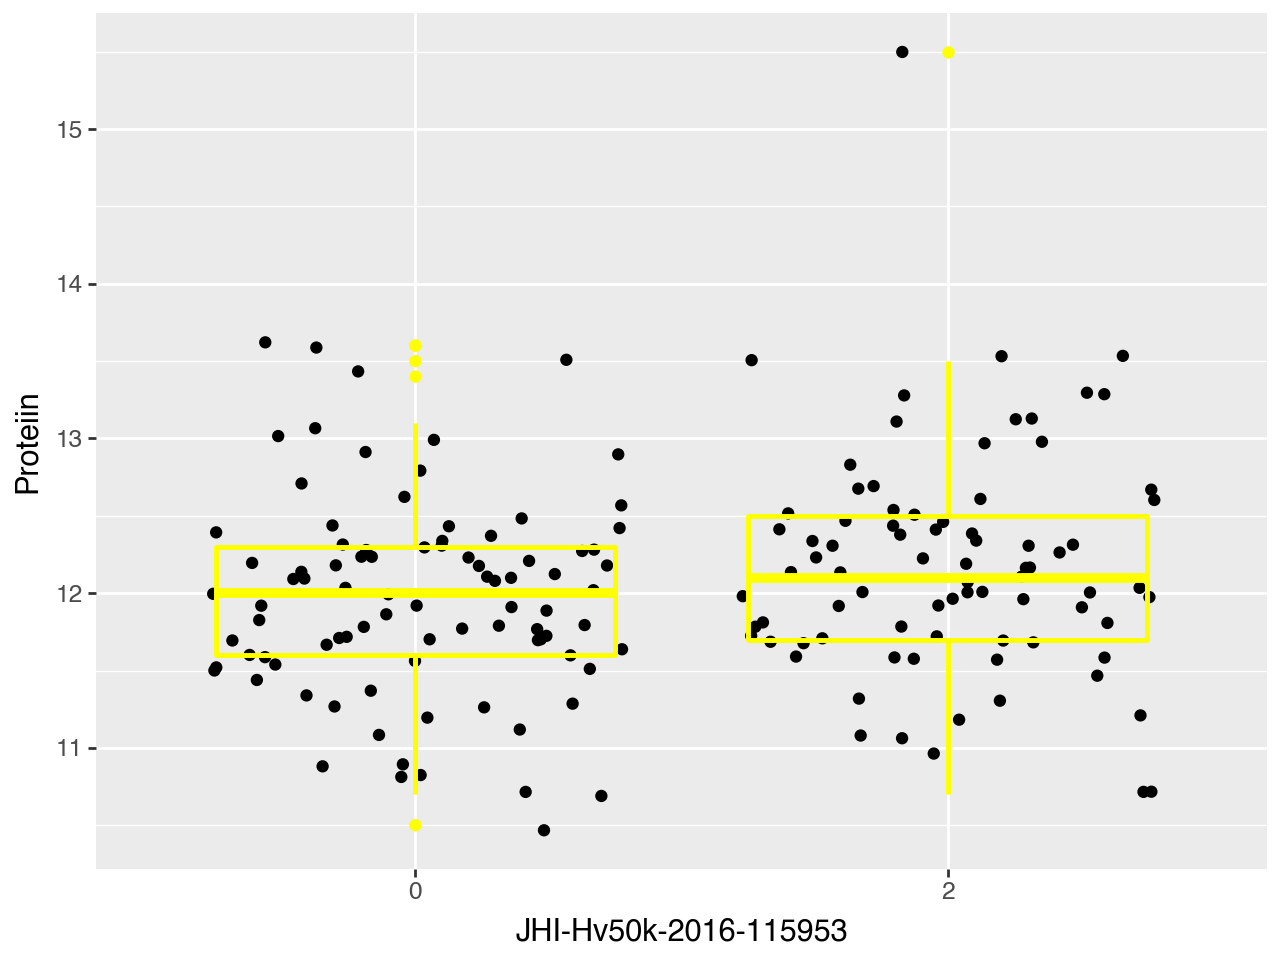

Plot for marker: SCRI_RS_150590


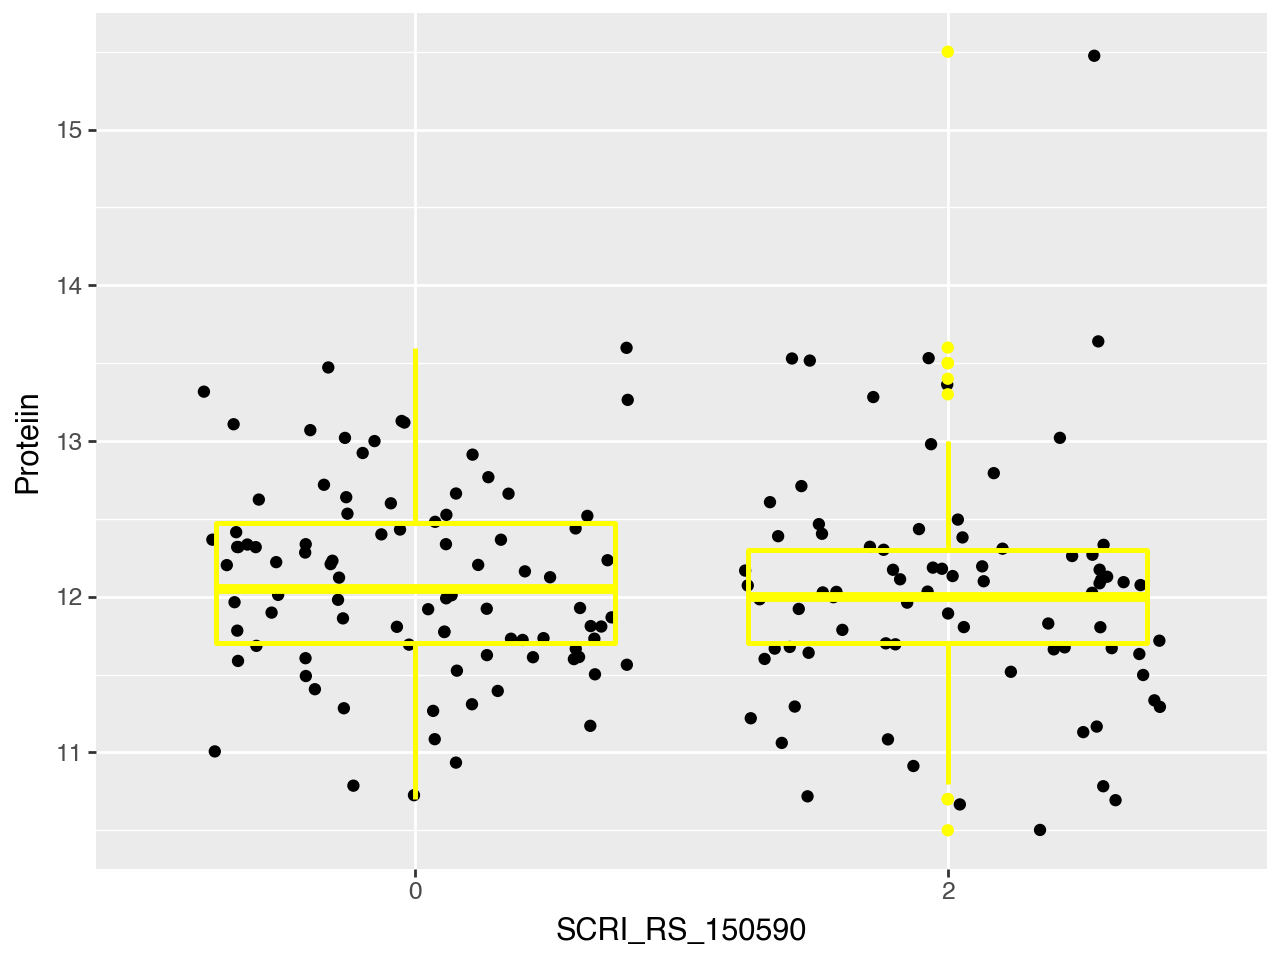

Plot for marker: JHI-Hv50k-2016-498


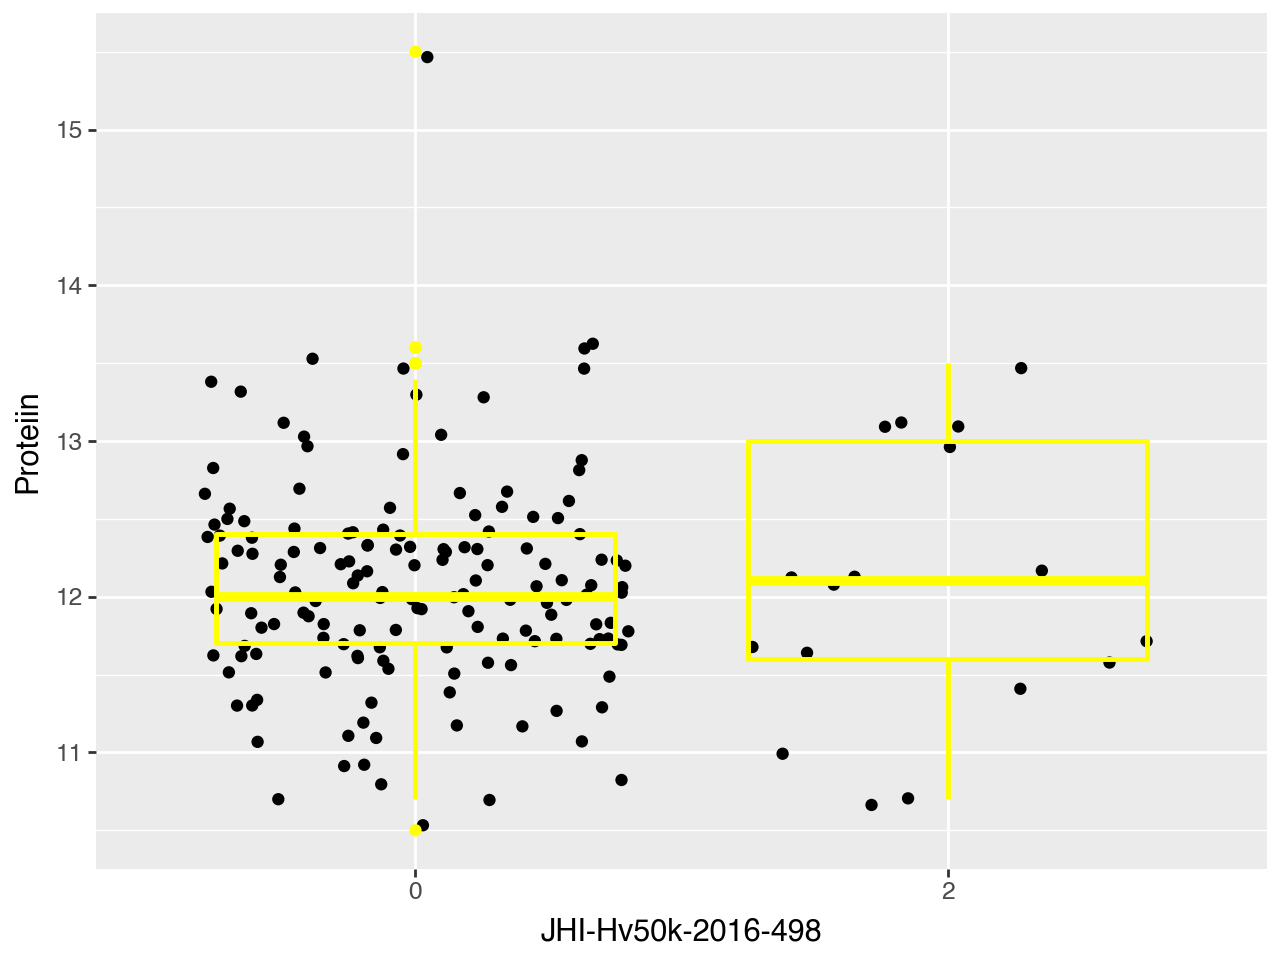

In [18]:
import plotnine as p9
import numpy as np

# Convert SNP data to strings and merge with protein content
snp_protein = snp_numeric_reduced.copy().astype(str)
snp_protein = snp_protein.merge(merged_data[['Nimi', 'Proteiin']], left_index=True, right_on='Nimi', how='left').drop(columns=['Nimi'])

# Replace '3' with NaN for missing values
snp_protein.replace('3', np.nan, inplace=True)

# Loop through each marker in markers_above_threshold
for marker in markers_above_threshold:
    
    # Drop rows with NaN in either the marker column or Protein Content
    snp_protein_clean = snp_protein.dropna(subset=[marker, 'Proteiin'])
    
    # Create the plot
    plot = (
        p9.ggplot(data=snp_protein_clean, mapping=p9.aes(x=marker, y='Proteiin')) +  # Plot mapping
        p9.geom_point(position='jitter') +  # Add jittered points
        p9.geom_boxplot(fill=None, color='yellow', size=1)  # Add boxplot with yellow borders
    )
    
    # Display the plot
    print(f"Plot for marker: {marker}")
    plot.show()



/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 5 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: /var/folders/lg/4b9nt_3d49913dlyt5h8824w0000gn/T/tmp5jluvnnl.png
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 5 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: /var/folders/lg/4b9nt_3d49913dlyt5h8824w0000gn/T/tmpjog8ma4g.png
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 5 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: /var/folders/lg/4b9nt_3d49913dlyt5h8824w0000gn/T/tmpjso4ggt7.png
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 5 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Fil

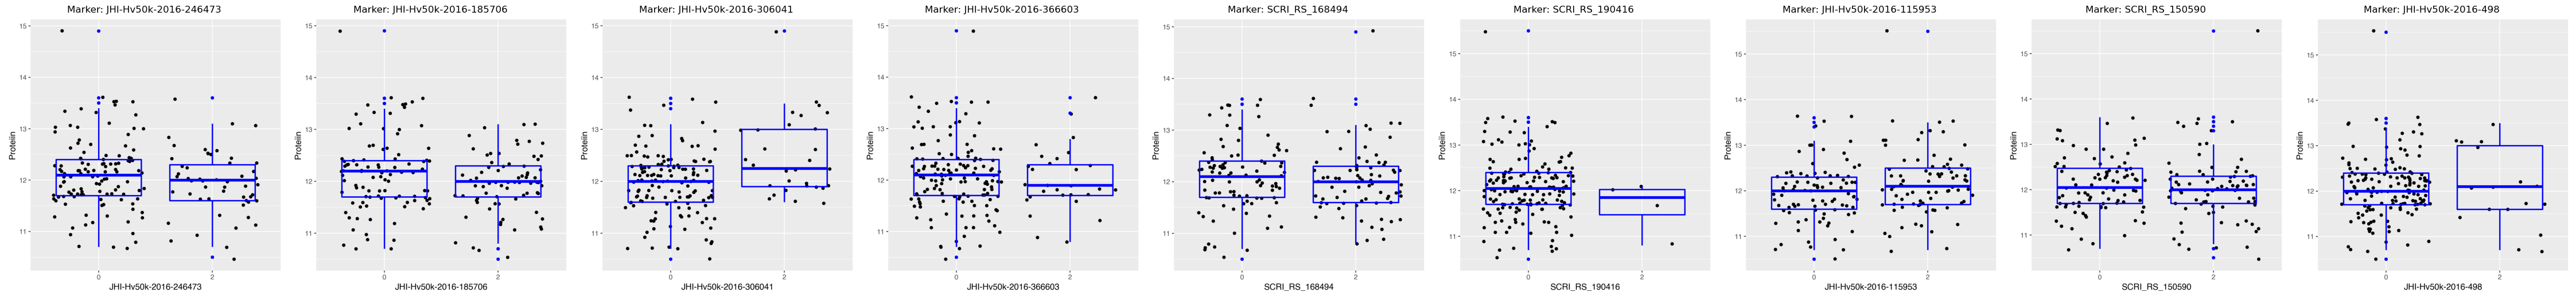

In [19]:
import matplotlib.pyplot as plt
import plotnine as p9
import numpy as np
import tempfile
from PIL import Image

# Convert SNP data to strings and merge with protein content
snp_protein = snp_numeric_reduced.copy().astype(str)
snp_protein = snp_protein.merge(merged_data[['Nimi', 'Proteiin']], left_index=True, right_on='Nimi', how='left').drop(columns=['Nimi'])

# Replace '3' with NaN for missing values
snp_protein.replace('3', np.nan, inplace=True)

# Number of markers to plot
num_markers = len(markers_above_threshold)

# Set up the figure for subplots
fig, axes = plt.subplots(nrows=1, ncols=num_markers, figsize=(5 * num_markers, 6))

# If only one marker, `axes` will be a single Axes object, so we wrap it in a list
if num_markers == 1:
    axes = [axes]

# Loop through each marker and create the plot for each subplot
for i, marker in enumerate(markers_above_threshold):
    
    # Drop rows with NaN in either the marker column or Protein Content
    snp_protein_clean = snp_protein.dropna(subset=[marker, 'Proteiin'])
    
    # Create the plot using plotnine
    plot = (
        p9.ggplot(data=snp_protein_clean, mapping=p9.aes(x=marker, y='Proteiin')) +  # Plot mapping
        p9.geom_point(position='jitter') +  # Add jittered points
        p9.geom_boxplot(fill=None, color='blue', size=1)  # Add boxplot with yellow borders
    )
    
    # Save the plot to a temporary file
    with tempfile.NamedTemporaryFile(delete=False, suffix='.png') as tmpfile:
        plot.save(tmpfile.name, width=5, height=5, dpi=300)

        # Open the saved plot image
        img = Image.open(tmpfile.name)

        # Place the image onto the corresponding subplot
        axes[i].imshow(img)
        axes[i].axis('off')  # Hide axis
        axes[i].set_title(f'Marker: {marker}')

# Adjust layout
plt.tight_layout()
plt.show()


## Use previous knowledge to predict

In [20]:
snp_prime = snp_numeric_reduced.copy()[markers_above_threshold]
snp_prime


,JHI-Hv50k-2016-246473,JHI-Hv50k-2016-185706,JHI-Hv50k-2016-306041,JHI-Hv50k-2016-366603,SCRI_RS_168494,SCRI_RS_190416,JHI-Hv50k-2016-115953,SCRI_RS_150590,JHI-Hv50k-2016-498
Nimi,,,,,,,,,
Amidala,0,2,0,0,0,0,2,2,0
Amy,2,2,0,0,0,0,2,0,0
Anneli,0,0,2,0,2,0,0,2,0
Anni,0,0,2,0,0,0,0,0,0
Annika,0,2,0,2,0,0,2,2,0
...,...,...,...,...,...,...,...,...,...
6006142,2,2,0,0,0,0,2,2,0
6006153,0,2,0,0,0,0,2,2,0
6011421,0,2,0,0,0,0,0,0,0


In [21]:
import statsmodels.api as sm

snp_protein= snp_protein.apply(pd.to_numeric, errors='coerce')

# Dependent variable (Protein content)
y = snp_protein['Proteiin']

# Independent variables (SNP data)
X = snp_prime.columns

# Add a constant to the independent variables matrix (for the intercept in the model)
X = sm.add_constant(X)

# Fit the General Linear Model (GLM)
model = sm.OLS(y, X).fit()

# Display the summary of the model
print(model.summary())


TypeError: unsupported operand type(s) for -: 'str' and 'str'

Explained Variance Ratio:
[0.18028407 0.16901834 0.13449526 0.11913725 0.09755399 0.08422569
 0.07925778 0.07587687 0.06015075]
Cumulative Explained Variance:
[0.18028407 0.34930241 0.48379767 0.60293493 0.70048891 0.7847146
 0.86397238 0.93984925 1.        ]


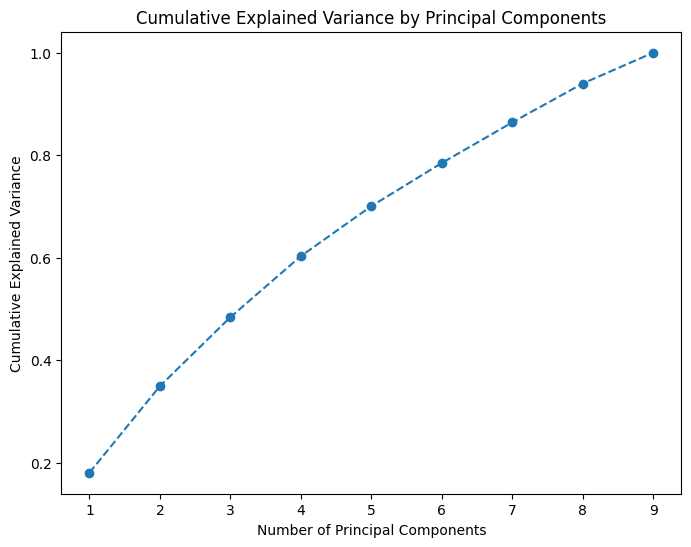

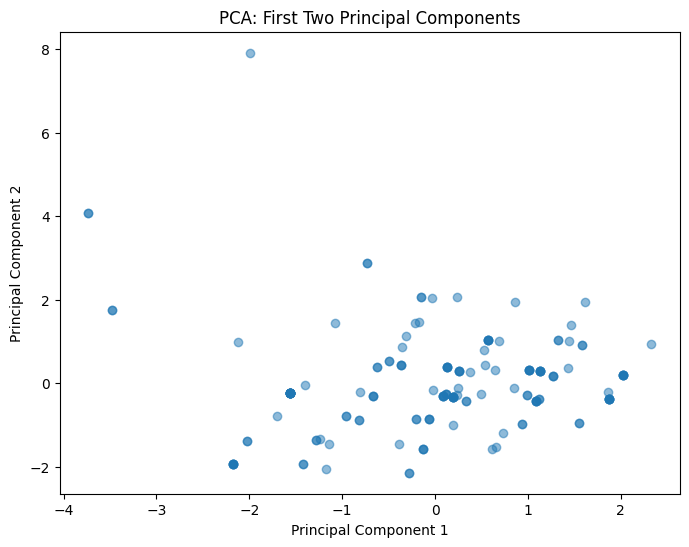

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming snp_protein is the DataFrame with SNP data (without the 'Proteiin' column)
# Selecting only the SNP columns (excluding 'Proteiin' or other non-SNP columns)


# Extract SNP data

snp_prime = snp_prime.dropna()


# 1. Standardizing the SNP data
scaler = StandardScaler()
snp_data_scaled = scaler.fit_transform(snp_prime)


# 2. Perform PCA
pca = PCA()
pca.fit(snp_data_scaled)

# 3. Explained Variance
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

# 4. Cumulative Explained Variance (Optional)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("Cumulative Explained Variance:")
print(cumulative_variance)

# 5. Plot the explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# 6. Get the principal components (the transformed SNP data)
snp_data_pca = pca.transform(snp_data_scaled)

# 7. Create a DataFrame for the principal components
pca_df = pd.DataFrame(data=snp_data_pca, columns=[f'PC{i+1}' for i in range(snp_data_pca.shape[1])])

# Optional: Visualize the first two principal components (2D scatter plot)
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
plt.title('PCA: First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
snp_data

,BK_01,BK_03,BK_05,BK_08,BK_10,BK_17,BK_19,BOPA1_10012-1239,BOPA1_10070-1435,BOPA1_1007-651,...,TGBA15K-TG0382,TGBA15K-TG0383,TGBA15K-TG0384,TGBA15K-TG0385,TGBA15K-TG0386,TGBA15K-TG0400,TGBA15K-TG0402_NC_MA,TGBA15K-TG0402_NG_MA,TGBA15K-TG0403,TGBA15K-TG0409


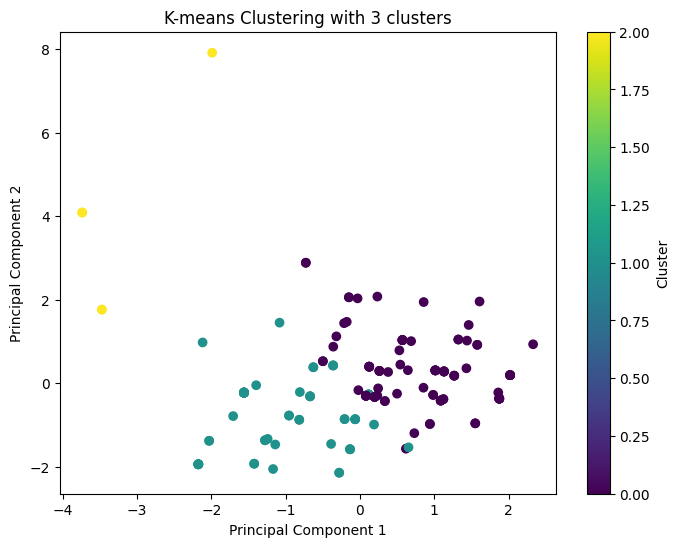

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Assuming snp_data is your SNP DataFrame

# Step 1: Impute missing values if necessary (as described before)
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
snp_data_imputed = imputer.fit_transform(snp_prime)

# Step 2: Standardize the data
scaler = StandardScaler()
snp_data_scaled = scaler.fit_transform(snp_data_imputed)

# Step 3: Apply K-means clustering (you need to choose the number of clusters k)
k = 3  # Example: setting number of clusters to 3
kmeans = KMeans(n_clusters=k, random_state=42)
snp_data_clusters = kmeans.fit_predict(snp_data_scaled)

# Step 4: Visualize the clusters (e.g., with the first two principal components)
# We can use PCA to reduce the dimensionality of the data for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=9)
snp_data_pca = pca.fit_transform(snp_data_scaled)

# Create a DataFrame with the PCA results and cluster labels
clustered_data = pd.DataFrame(snp_data_pca, columns=['PC1', 'PC2','PC3', 'PC4','PC5', 'PC6','PC7', 'PC8','PC9'])
clustered_data['Cluster'] = snp_data_clusters

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(clustered_data['PC1'], clustered_data['PC2'], c=clustered_data['Cluster'], cmap='viridis')
plt.title(f'K-means Clustering with {k} clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


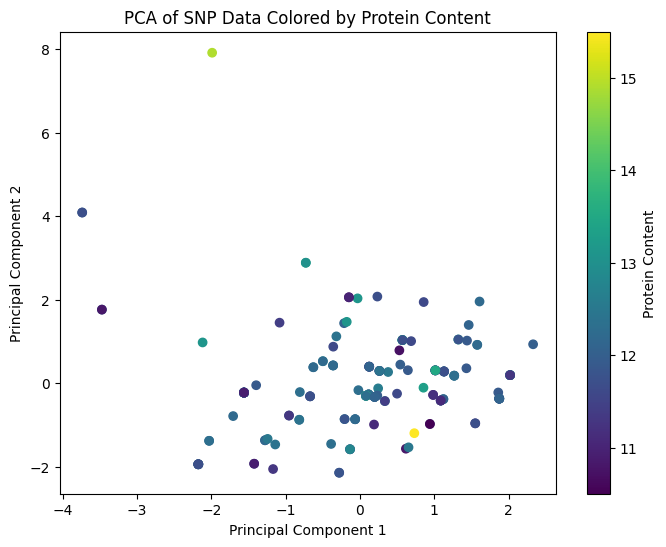

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Assuming you have your SNP data in snp_prime (with missing values)
# and protein content in snp_protein['Proteiin']

# Step 1: Impute missing values
imputer = SimpleImputer(strategy='mean')
snp_data_imputed = imputer.fit_transform(snp_prime)

# Step 2: Standardize the data
scaler = StandardScaler()
snp_data_scaled = scaler.fit_transform(snp_data_imputed)

# Step 3: Apply K-means clustering (you need to choose the number of clusters k)
k = 3  # Example: setting number of clusters to 3
kmeans = KMeans(n_clusters=k, random_state=42)
snp_data_clusters = kmeans.fit_predict(snp_data_scaled)

# Step 4: Perform PCA for visualization
pca = PCA(n_components=2)
snp_data_pca = pca.fit_transform(snp_data_scaled)

# Step 5: Create a DataFrame with the PCA results and cluster labels
clustered_data = pd.DataFrame(snp_data_pca, columns=['PC1', 'PC2'])
clustered_data['Cluster'] = snp_data_clusters

# Assuming snp_protein['Proteiin'] has the protein content for each sample,
# Merge protein content with the PCA results
# Make sure snp_protein['Proteiin'] aligns with snp_prime by index
clustered_data['Proteiin'] = snp_protein['Proteiin'].values  # Add protein content to the DataFrame

# Step 6: Plot the clusters colored by protein content
plt.figure(figsize=(8, 6))
scatter = plt.scatter(clustered_data['PC1'], clustered_data['PC2'], c=clustered_data['Proteiin'], cmap='viridis')
plt.title('PCA of SNP Data Colored by Protein Content')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Protein Content')  # Add colorbar to indicate protein content
plt.show()


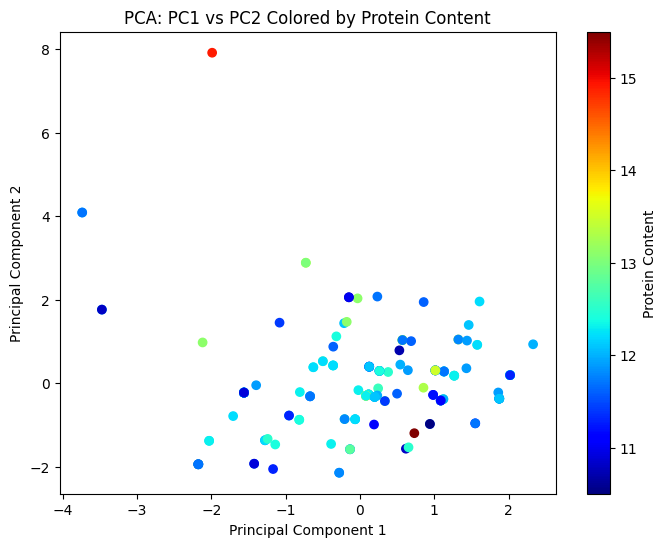

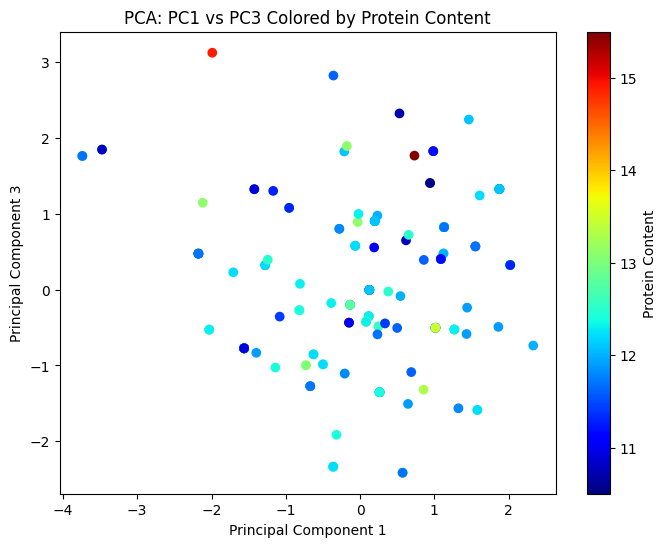

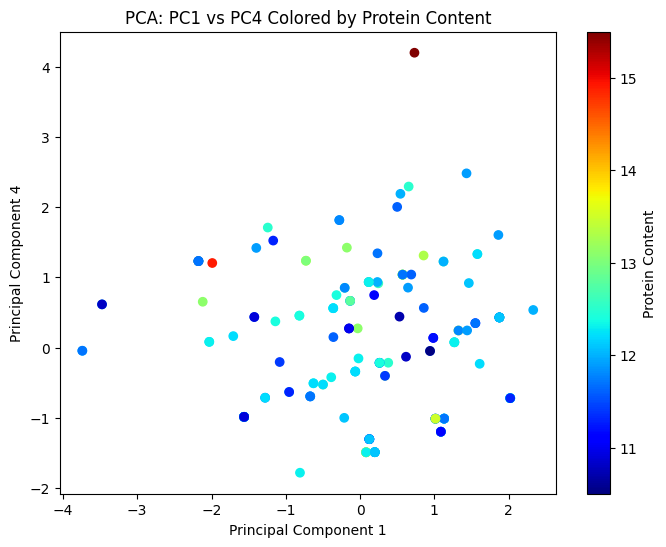

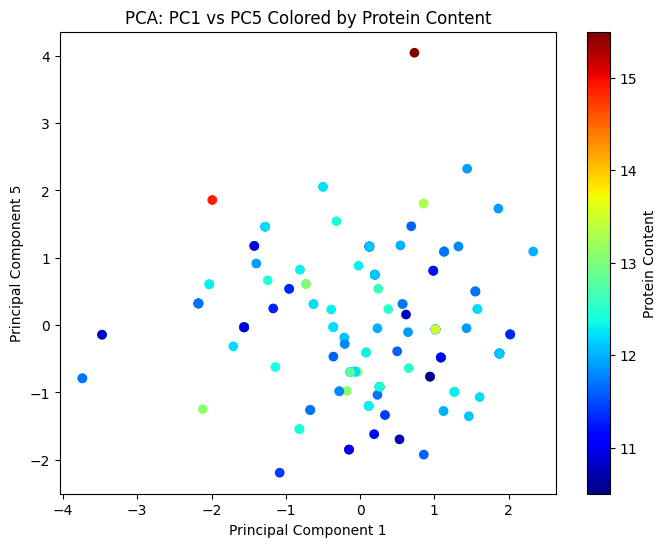

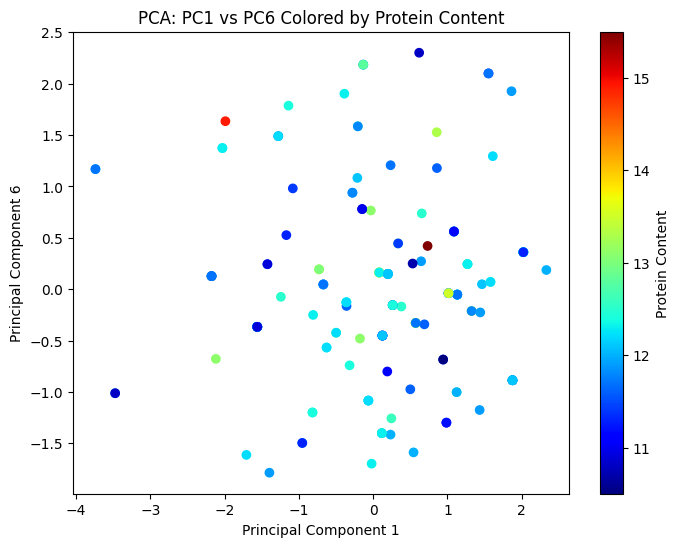

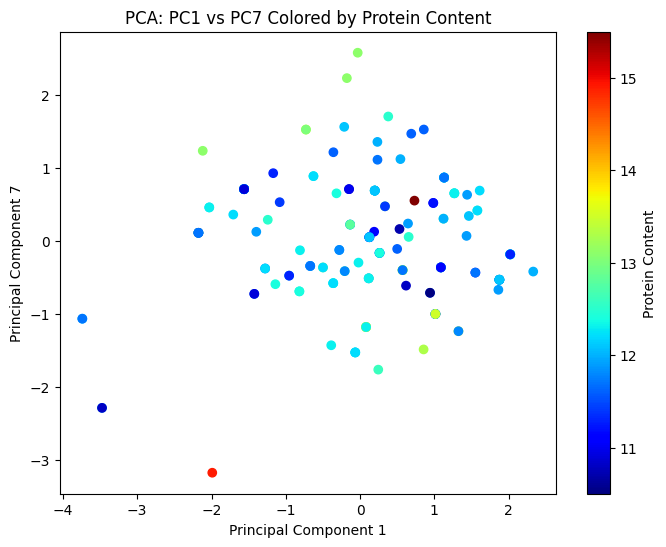

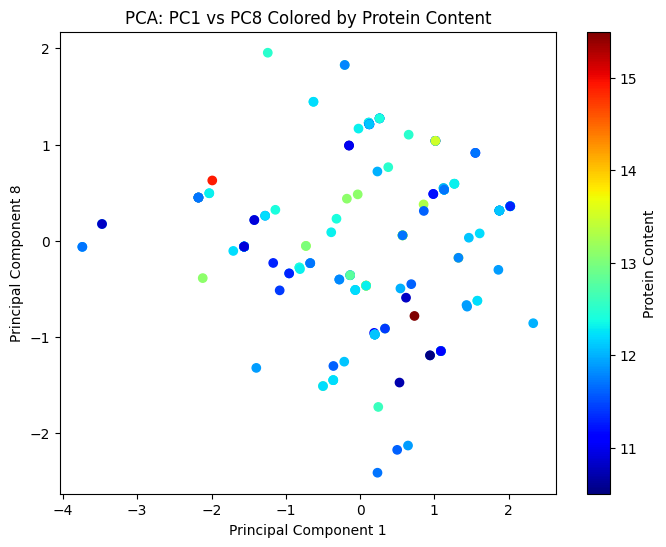

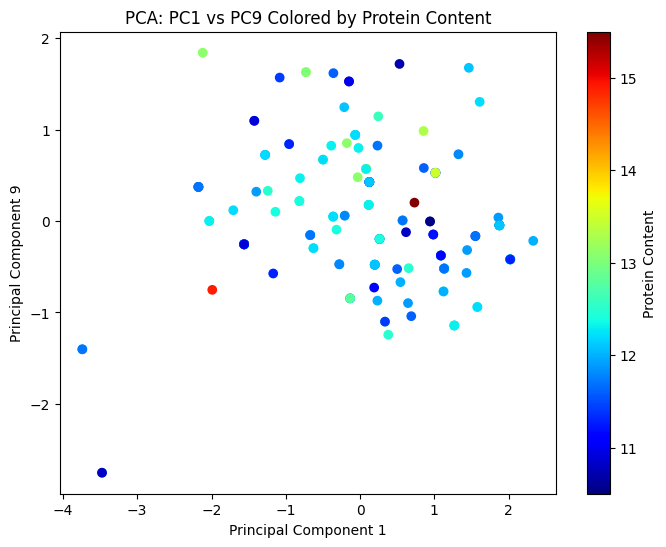

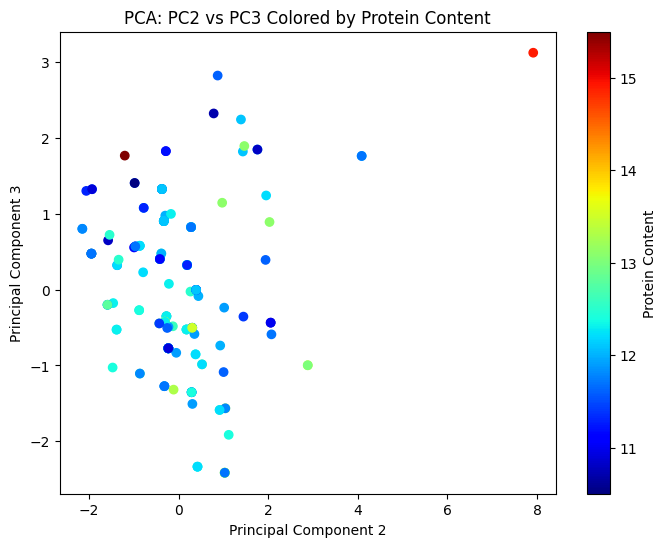

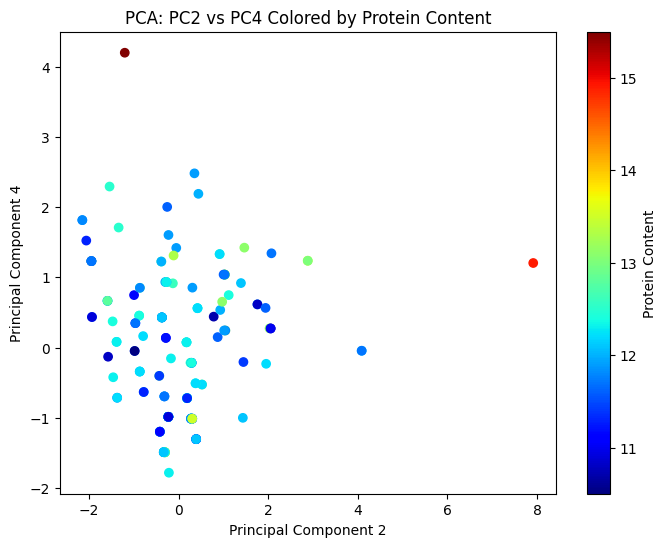

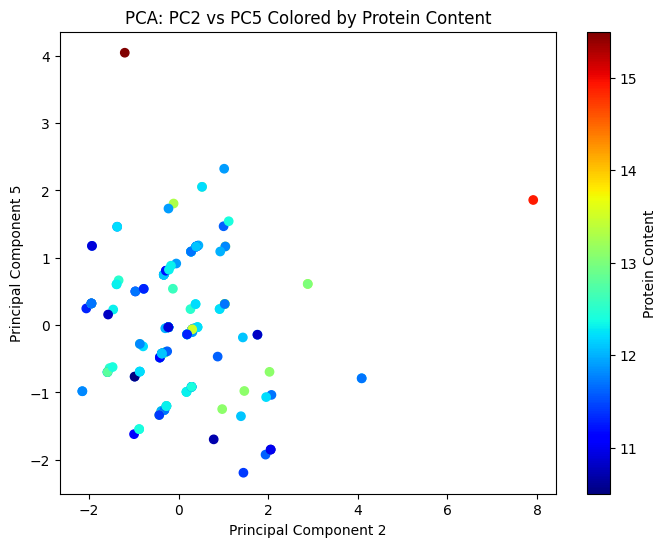

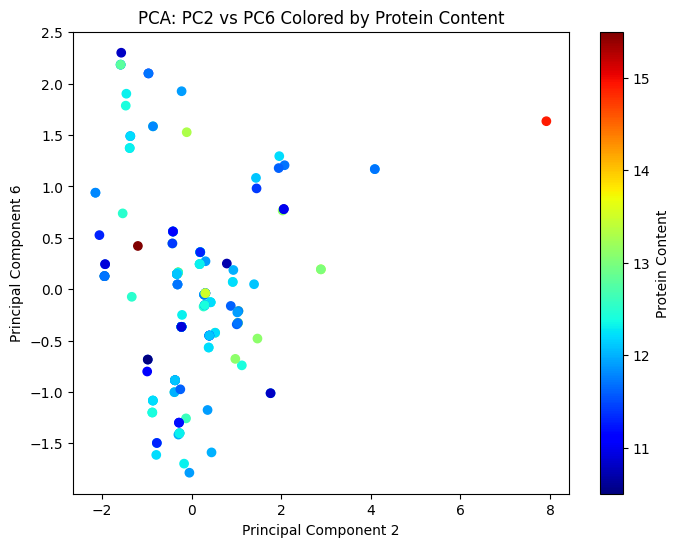

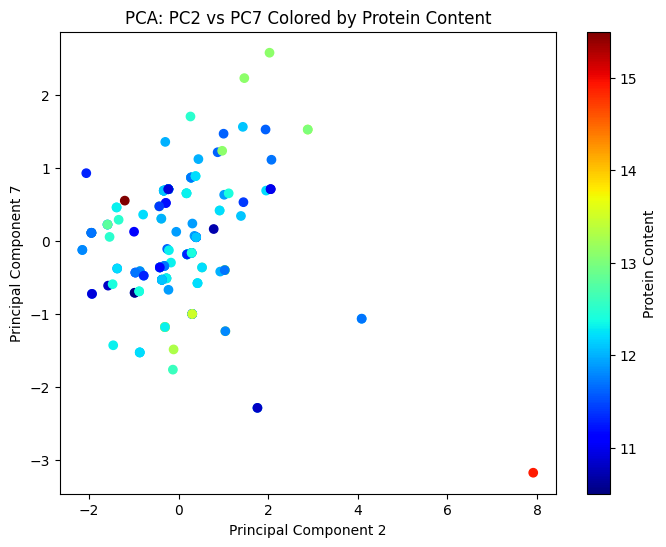

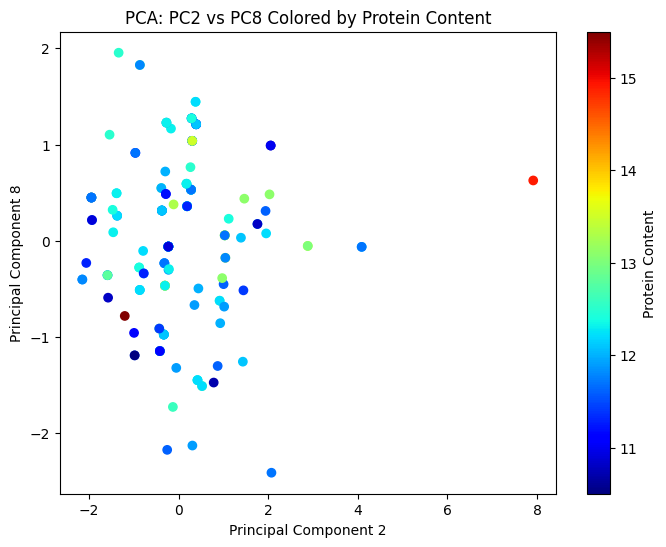

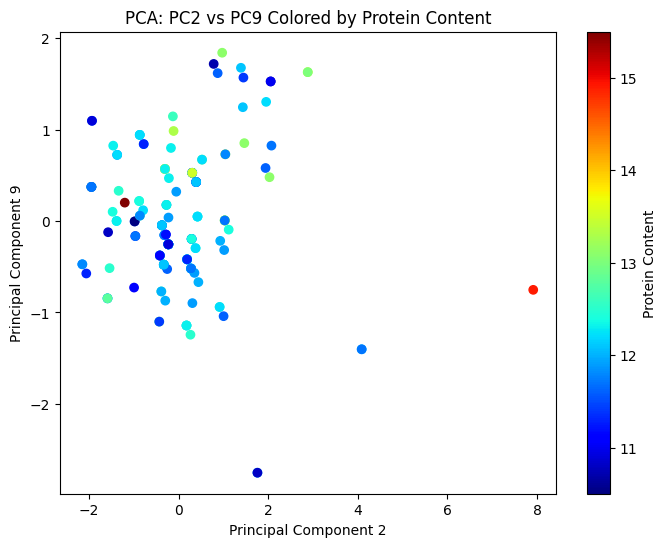

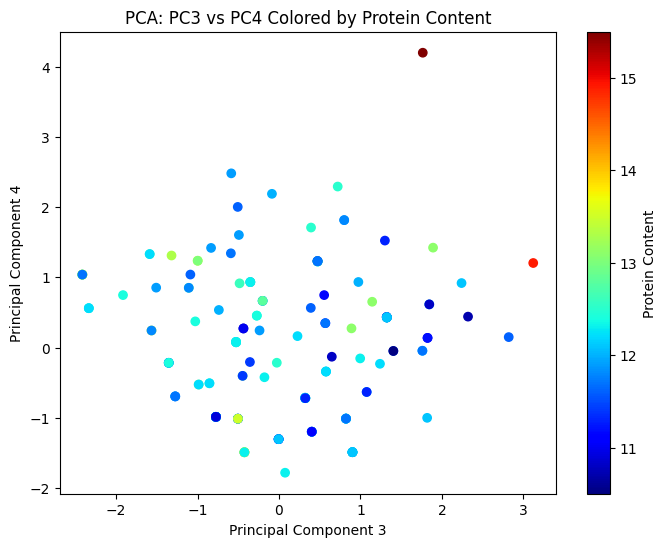

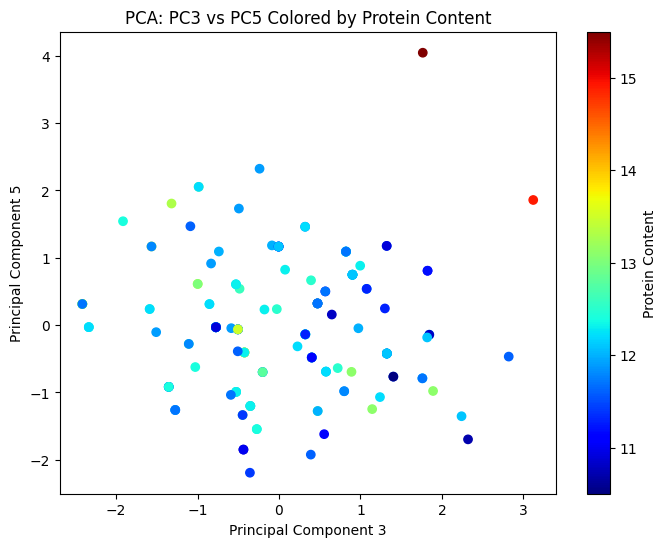

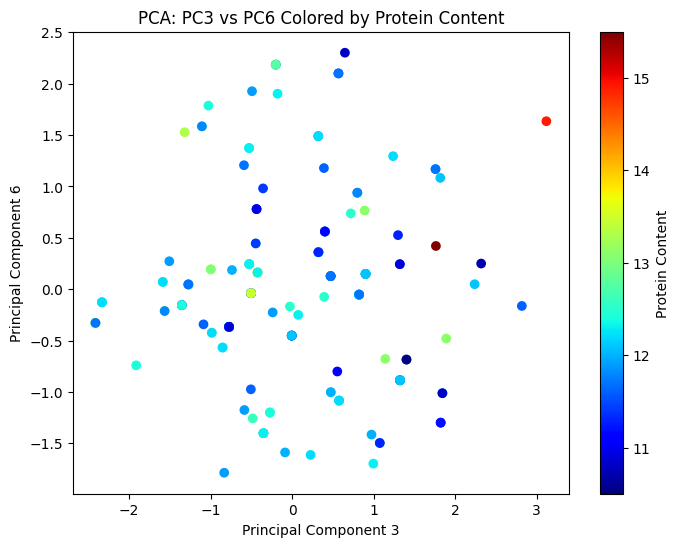

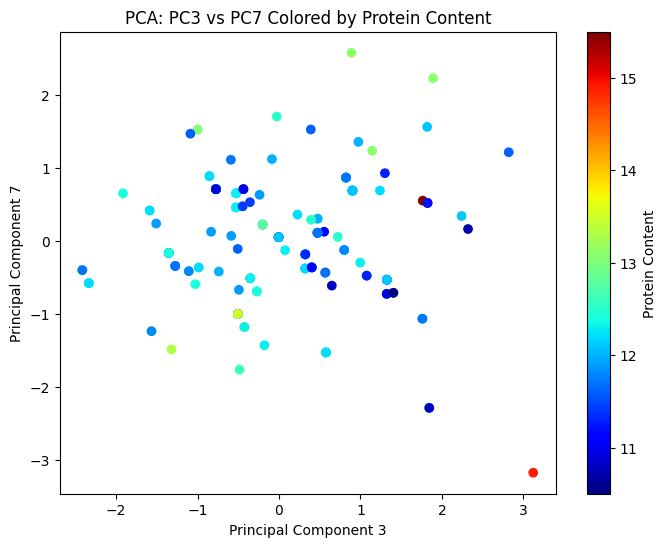

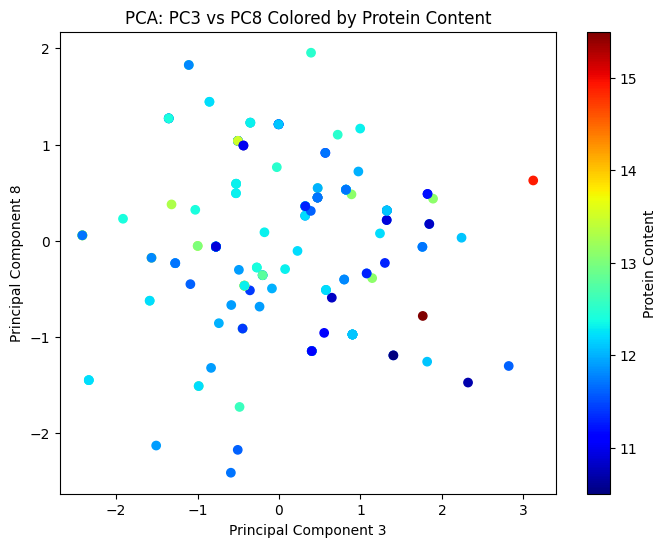

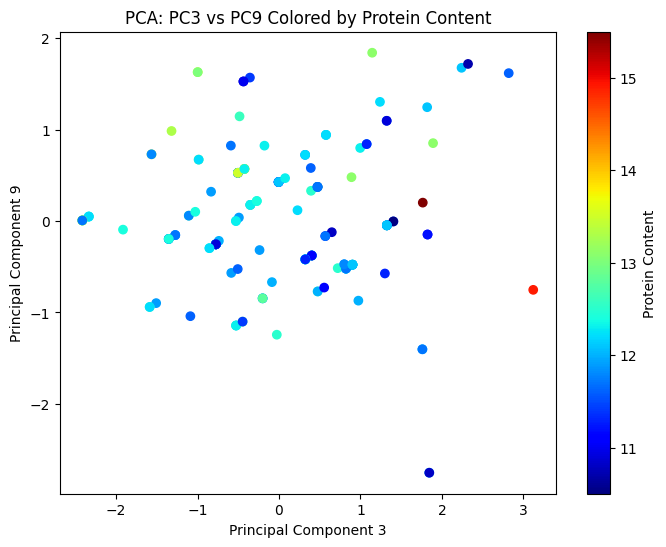

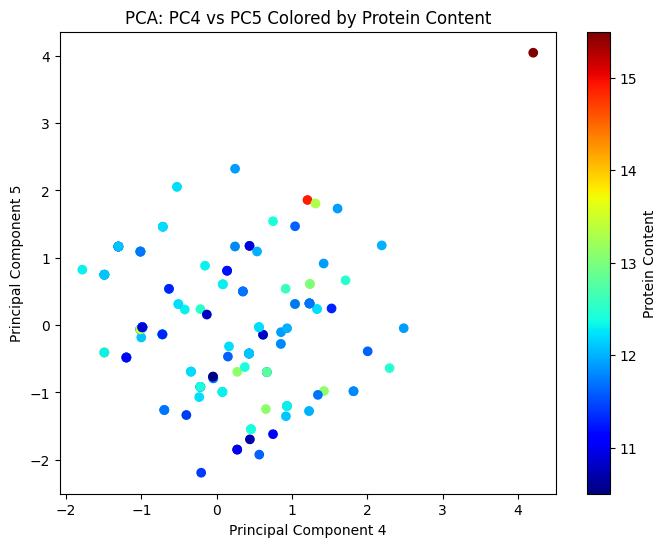

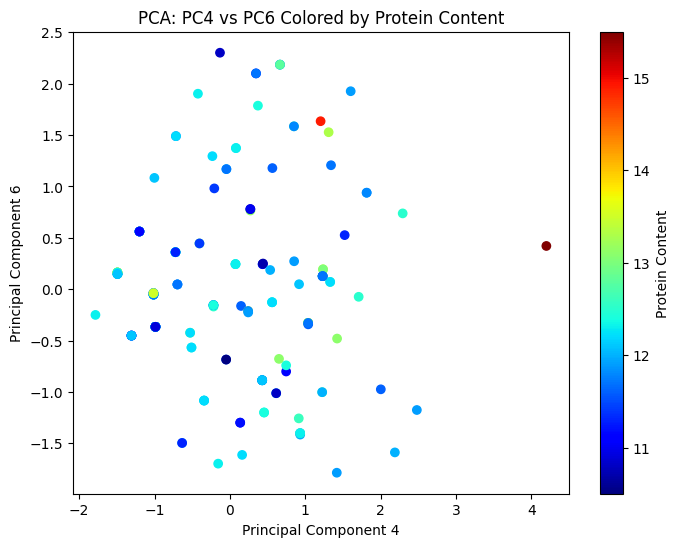

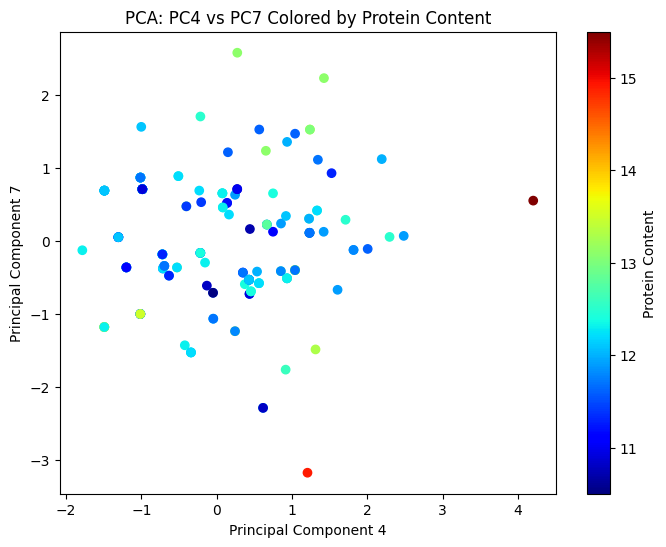

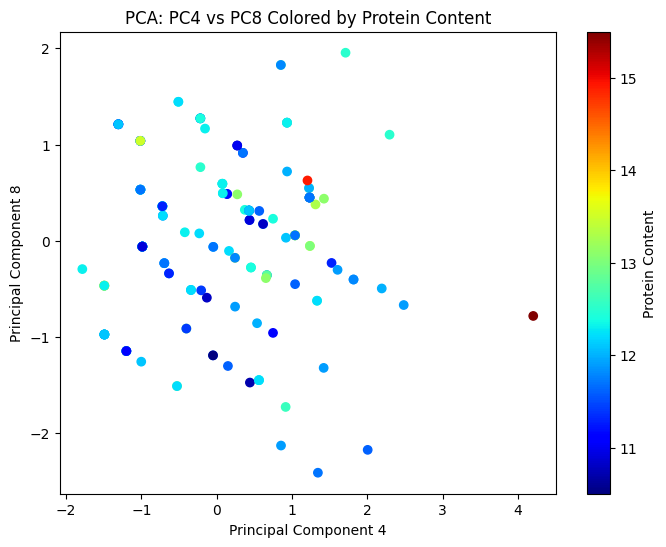

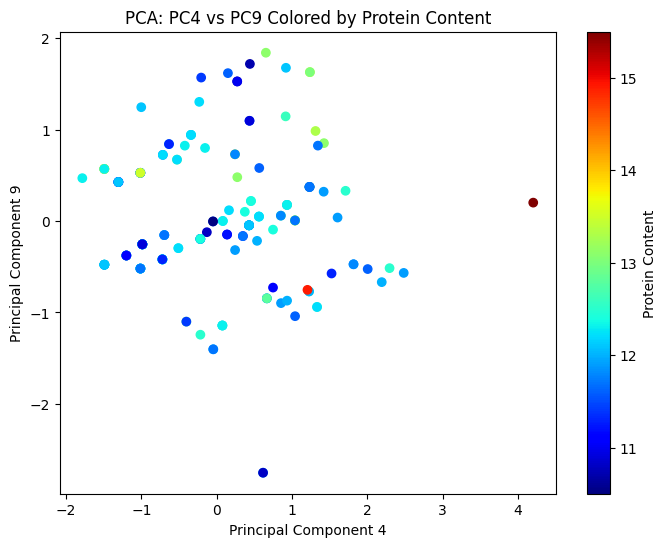

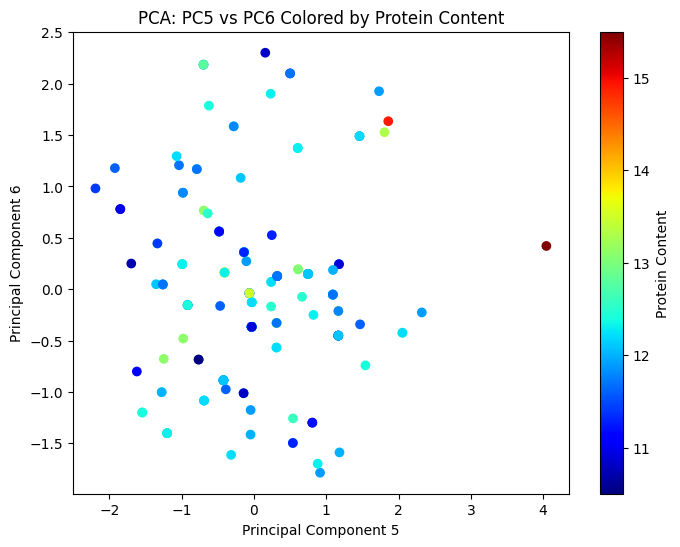

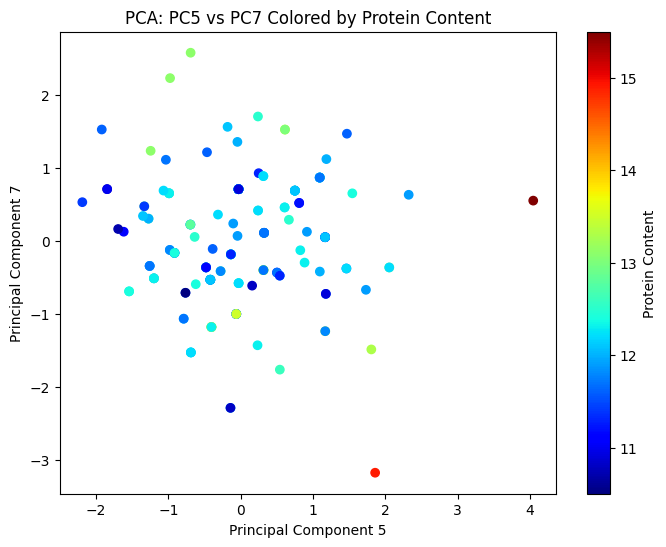

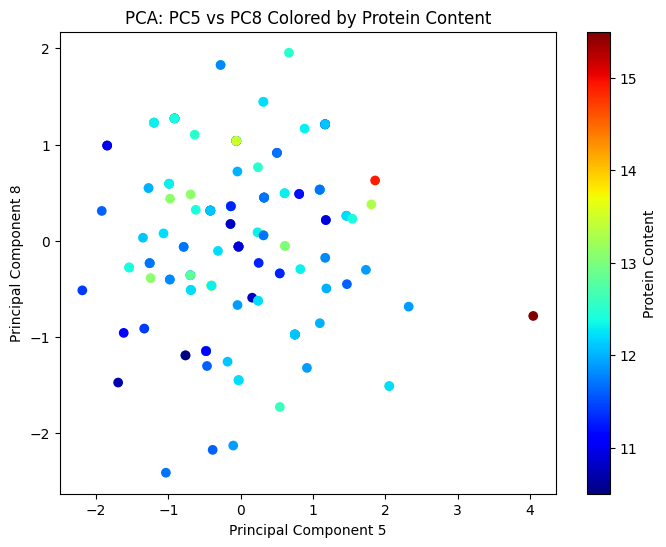

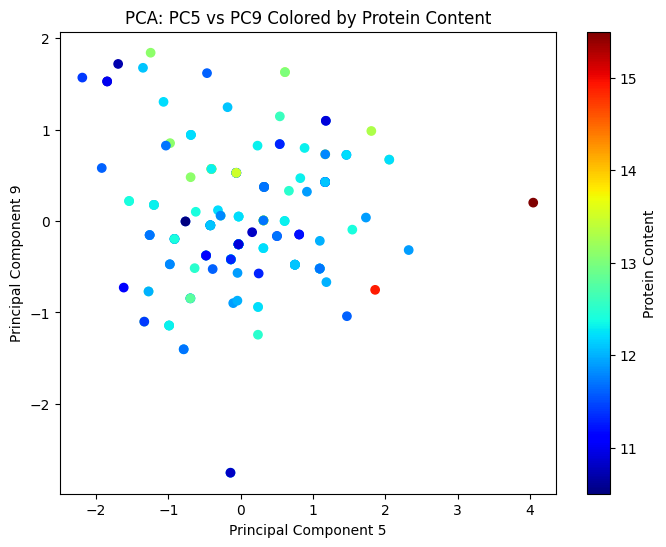

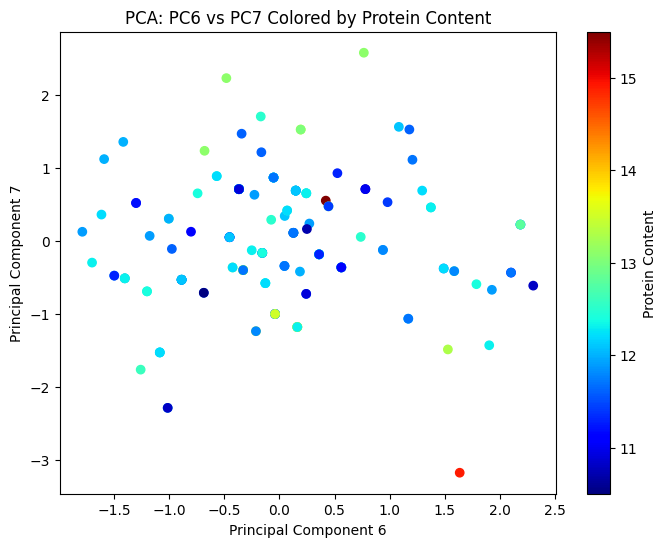

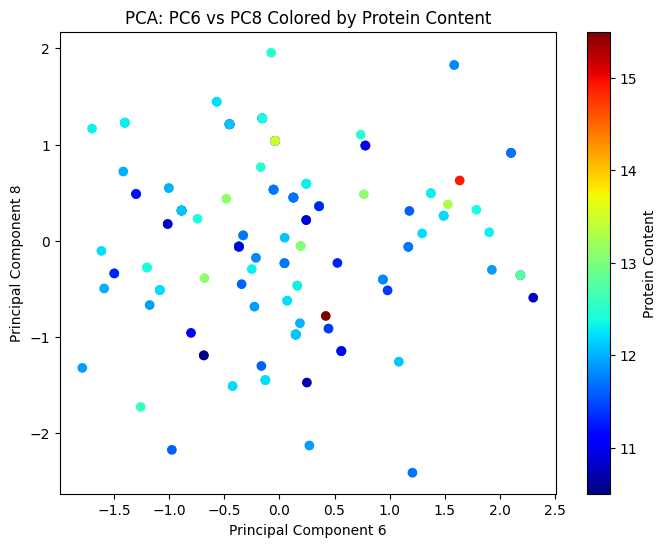

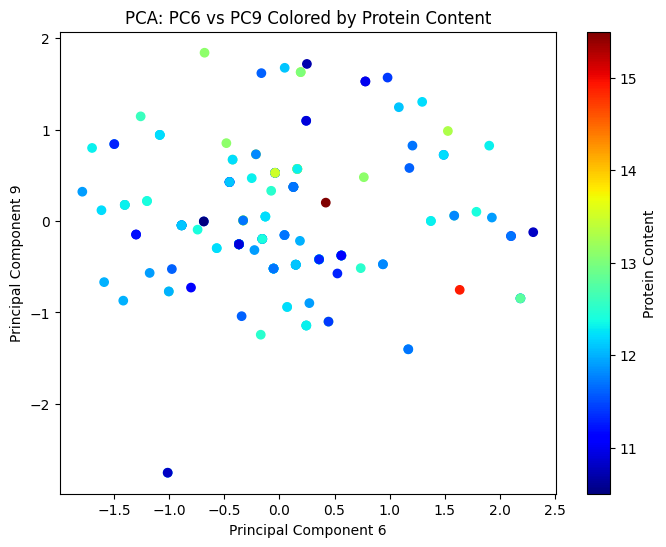

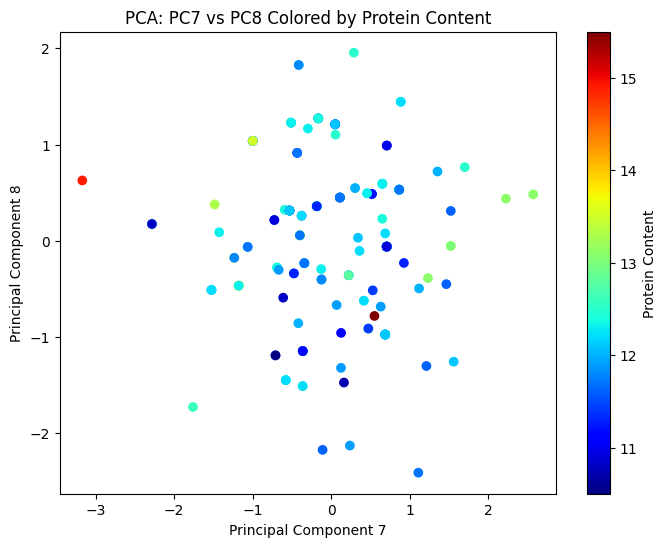

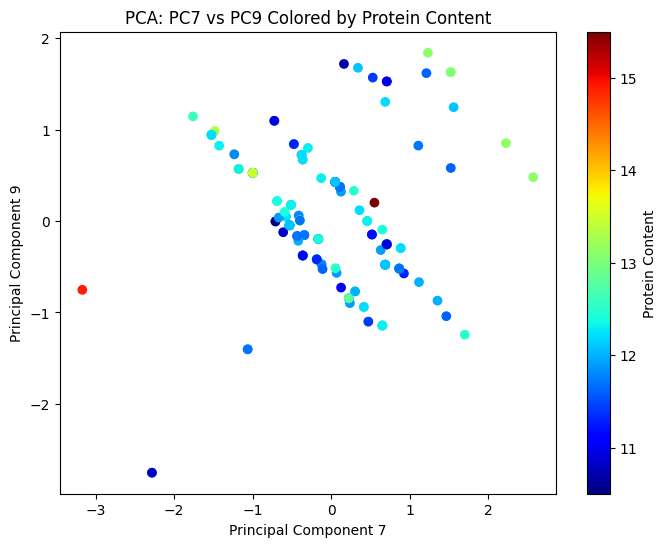

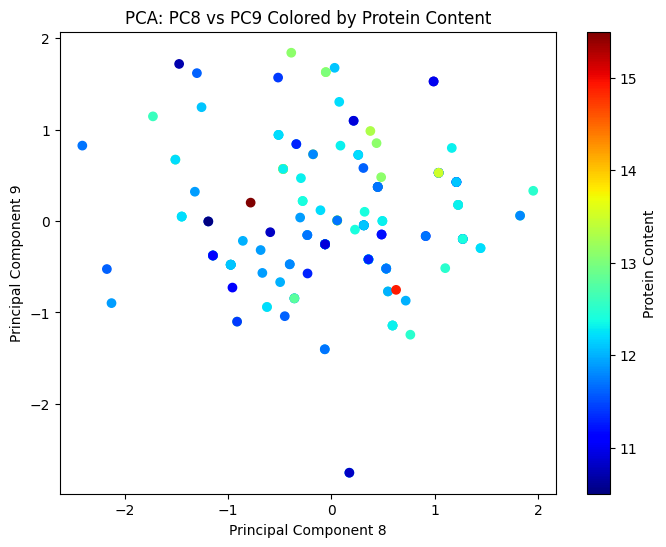

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns

# Assuming you have your SNP data in snp_prime (with missing values)
# and protein content in snp_protein['Proteiin']

# Step 1: Impute missing values
imputer = SimpleImputer(strategy='mean')
snp_data_imputed = imputer.fit_transform(snp_prime)

# Step 2: Standardize the data
scaler = StandardScaler()
snp_data_scaled = scaler.fit_transform(snp_data_imputed)

# Step 3: Apply K-means clustering (you need to choose the number of clusters k)
k = 3  # Example: setting number of clusters to 3
kmeans = KMeans(n_clusters=k, random_state=42)
snp_data_clusters = kmeans.fit_predict(snp_data_scaled)

# Step 4: Perform PCA for visualization (let's keep more components)
pca = PCA(n_components=9)  # Using 5 components for illustration, can be adjusted
snp_data_pca = pca.fit_transform(snp_data_scaled)

# Step 5: Create a DataFrame with the PCA results and cluster labels
clustered_data = pd.DataFrame(snp_data_pca, columns=[f'PC{i+1}' for i in range(snp_data_pca.shape[1])])
clustered_data['Cluster'] = snp_data_clusters
clustered_data['Proteiin'] = snp_protein['Proteiin'].values  # Add protein content to the DataFrame

# Step 6: Plot all pairs of PCA components, colored by protein content
num_components = snp_data_pca.shape[1]

# Create a pair of plots for all combinations of PCA components
for i in range(num_components):
    for j in range(i+1, num_components):
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(
            clustered_data[f'PC{i+1}'], 
            clustered_data[f'PC{j+1}'], 
            c=clustered_data['Proteiin'], 
            cmap='jet'
        )
        plt.title(f'PCA: PC{i+1} vs PC{j+1} Colored by Protein Content')
        plt.xlabel(f'Principal Component {i+1}')
        plt.ylabel(f'Principal Component {j+1}')
        plt.colorbar(scatter, label='Protein Content')  # Colorbar to indicate protein content
        plt.show()


C:\Users\kivis\AppData\Local\Temp\ipykernel_9592\1162967119.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



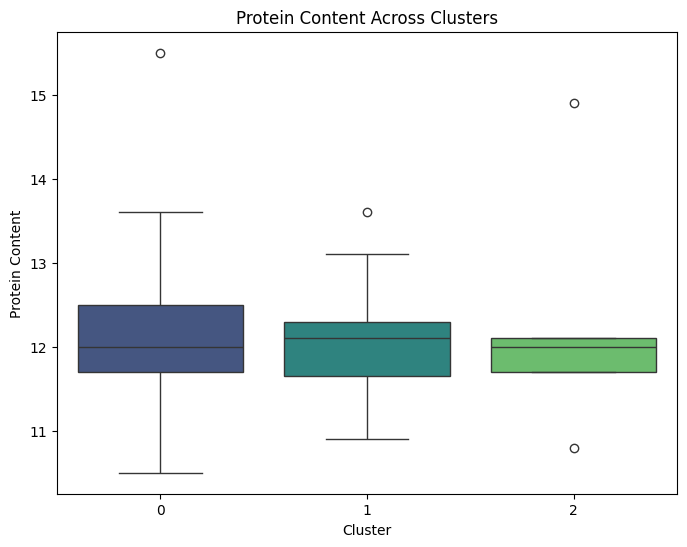

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have the following:
# snp_data_clusters: Clusters assigned to each sample after clustering
# snp_protein: Original DataFrame with protein content 'Proteiin'

# Add cluster information to the protein data
snp_protein['Cluster'] = snp_data_clusters

# Plot protein content distribution across clusters using boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y='Proteiin', data=snp_protein, palette='viridis')
plt.title('Protein Content Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Protein Content')
plt.show()


In [ ]:
from scipy import stats

# Perform ANOVA to check if protein content varies significantly across clusters
anova_result = stats.f_oneway(
    *[snp_protein[snp_protein['Cluster'] == i]['Proteiin'] for i in range(len(set(snp_protein['Cluster'])))])
    
print(f"ANOVA test result: F-statistic = {anova_result.statistic}, p-value = {anova_result.pvalue}")


ANOVA test result: F-statistic = 0.7164201124020261, p-value = 0.4899841344045177
